In [17]:
!pip install -q paramiko
!git clone https://github.com/alan-turing-institute/CybORG_plus_plus
!pip install -q gym==0.21.0 numpy networkx prettytable ipython

import sys
sys.path.insert(0, '/content/CybORG_plus_plus/Debugged_CybORG/CybORG')

import inspect
from CybORG import CybORG
from CybORG.Agents import B_lineAgent, SleepAgent
from CybORG.Agents.Wrappers import ChallengeWrapper

# Get scenario path
path = str(inspect.getfile(CybORG))
path = path[:-10] + '/Shared/Scenarios/Scenario1b.yaml'

cyborg = CybORG(path, 'sim', agents={'Red': B_lineAgent})
env = ChallengeWrapper(env=cyborg, agent_name='Blue')

obs, info = env.reset()
print(f"Observation shape: {obs.shape}, Action space: {env.action_space.n}")

done = False
total_reward = 0
step = 0
while not done and step < 100:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    step += 1

print(f"Completed {step} steps, Total reward: {total_reward:.2f}")

fatal: destination path 'CybORG_plus_plus' already exists and is not an empty directory.
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
CybORG++ is now working!
Observation shape: (52,)
Action space size: 54

Completed 100 steps
Total reward: -929.30


In [18]:
import torch, random, numpy as np
from dataclasses import dataclass
import inspect, os
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@dataclass
class Config:
    seed: int = 42
    max_episode_steps: int = 64
    hidden_dim: int = 64

cfg = Config()
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if device.type == "cuda":
    torch.cuda.manual_seed_all(cfg.seed)

cyborg_file = Path(inspect.getfile(CybORG))
base_dir = cyborg_file.parent
scenario_path = base_dir / "Shared" / "Scenarios" / "Scenario1b.yaml"

if not scenario_path.exists():
    raise FileNotFoundError(f"Scenario1b.yaml not found at {scenario_path}")
print("Scenario path found:", scenario_path)


Using device: cpu
Scenario path found: /content/CybORG_plus_plus/Debugged_CybORG/CybORG/CybORG/Shared/Scenarios/Scenario1b.yaml


In [19]:
cyborg = CybORG(str(scenario_path), 'sim', agents={'Red': B_lineAgent})
env = ChallengeWrapper(env=cyborg, agent_name='Blue')

obs, info = env.reset()
print(f"Observation: {type(obs).__name__}, Action space: {env.action_space}")

done, total_reward, step = False, 0, 0
while not done and step < 50:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    step += 1

print(f"Completed {step} steps | Total reward: {total_reward:.2f}")


SUCCESS! Debugged-CybORG environment ready.
Observation type: <class 'numpy.ndarray'>
Action space: Discrete(54)
Completed 50 steps | Total reward: -121.80


In [20]:
import inspect
from pathlib import Path
from CybORG import CybORG
from CybORG.Agents import B_lineAgent, SleepAgent
from CybORG.Agents.Wrappers import ChallengeWrapper

cyborg_file = Path(inspect.getfile(CybORG))
scenario_path = cyborg_file.parent / "Shared" / "Scenarios" / "Scenario1b.yaml"
assert scenario_path.exists(), f"Scenario YAML not found: {scenario_path}"

cyborg = CybORG(str(scenario_path), 'sim', agents={'Red': B_lineAgent})
env = ChallengeWrapper(env=cyborg, agent_name='Blue')

obs, info = env.reset()
print(f"Observation: {type(obs).__name__}, Action space: {env.action_space}")


Using Scenario YAML: /content/CybORG_plus_plus/Debugged_CybORG/CybORG/CybORG/Shared/Scenarios/Scenario1b.yaml
Observation type: <class 'numpy.ndarray'>
Action space: Discrete(54)


In [21]:
done, total_reward, steps = False, 0.0, 0

while not done and steps < 100:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    steps += 1

print(f"Steps: {steps}, Total reward: {total_reward:.2f}")


Debugged_CybORG scenario test complete.
Total steps: 100
Total reward: -1105.60


In [22]:
# PettingZoo-like Wrapper
class DebuggedCyborgWrapper:
    """Thin adapter to mimic PettingZoo's multi-agent interface for later phases."""
    def __init__(self, env, max_steps=64):
        self.env = env
        self.max_steps = max_steps
        self.t = 0
        self.agents = ['Blue']
        self.action_space = env.action_space

    def reset(self):
        self.t = 0
        obs, info = self.env.reset()
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.t += 1
        if self.t >= self.max_steps:
            truncated = True
        return obs, reward, terminated, truncated, info

wrapper = DebuggedCyborgWrapper(env, max_steps=64)
print("Wrapper ready. Controlled agent:", wrapper.agents)


Wrapper ready. Controlled agent: ['Blue']


TESTING IMPROVED GRAPH EXTRACTION

Hosts: ['Defender', 'Enterprise0', 'Enterprise1', 'Enterprise2', 'Op_Host0', 'Op_Host1', 'Op_Host2', 'Op_Server0', 'User0', 'User1', 'User2', 'User3', 'User4']
Adjacency shape: (13, 13) | Node feature shape: (13, 10)
Non-zero connections: 22 edges


/tmp/ipython-input-759627598.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


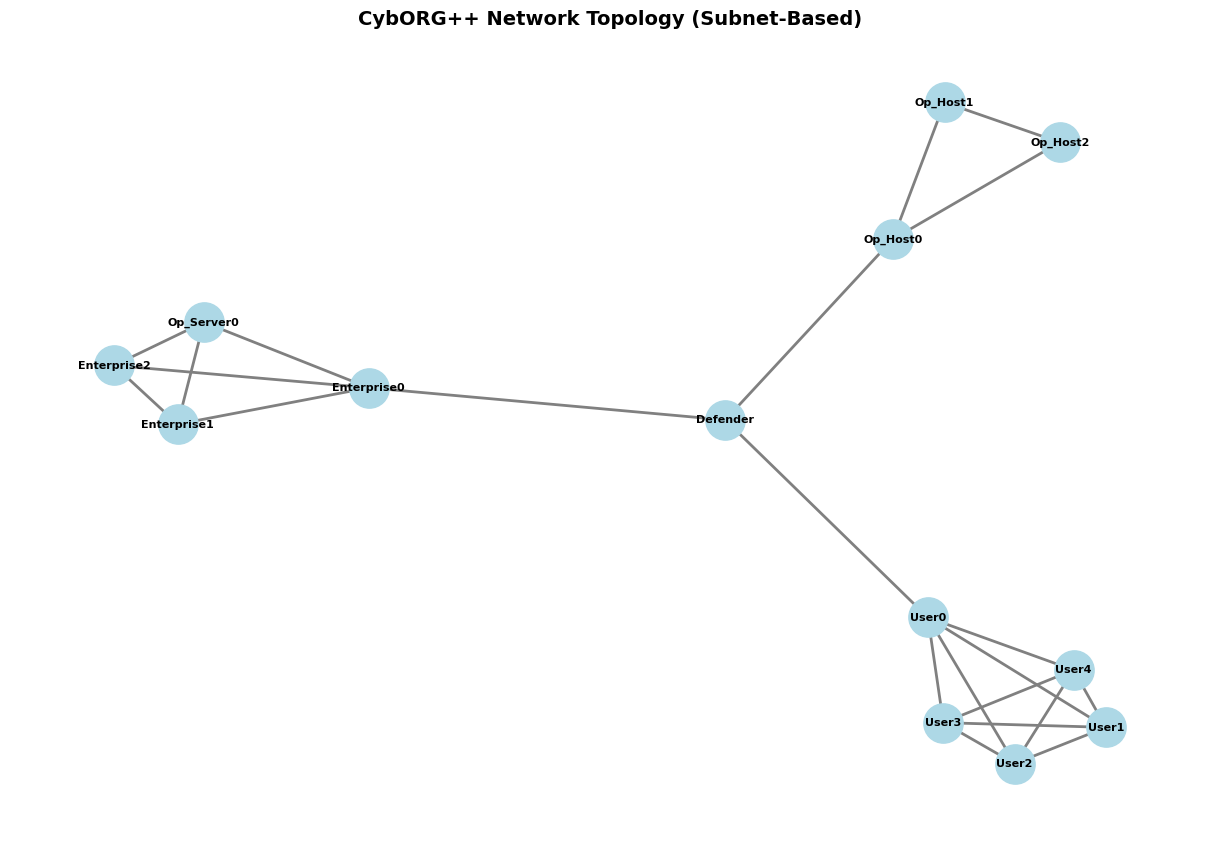

In [23]:
import numpy as np

def get_graph_with_subnet_structure(cyborg):
    """Extract graph with subnet-based topology for CybORG Scenario 1b."""
    state = cyborg.environment_controller.state
    hosts = sorted(list(state.hosts.keys()))
    n = len(hosts)
    host_to_idx = {h: i for i, h in enumerate(hosts)}

    compromised_hosts = set()
    if hasattr(state, 'sessions') and 'Red' in state.sessions:
        red_sessions = state.sessions['Red']
        iterator = red_sessions.values() if isinstance(red_sessions, dict) else red_sessions
        for session in iterator:
            h_name = getattr(session, 'hostname', None) or getattr(session, 'host', None)
            if h_name:
                compromised_hosts.add(h_name)

    A = np.zeros((n, n), dtype=np.float32)
    X = np.zeros((n, 10), dtype=np.float32)

    subnet_1 = [h for h in hosts if 'User' in h]
    subnet_2 = [h for h in hosts if 'Enterprise' in h or 'Op_Server' in h]
    subnet_3 = [h for h in hosts if 'Op_Host' in h]
    gateway = [h for h in hosts if 'Defender' in h]

    for i, host_name in enumerate(hosts):
        host = state.hosts[host_name]
        os_type = str(getattr(host, "os_type", "Unknown"))

        X[i, 0] = 1.0 if "Windows" in os_type else 0.0
        X[i, 1] = 1.0 if "Linux" in os_type else 0.0
        X[i, 2] = len(getattr(host, "processes", []))
        X[i, 3] = len(getattr(host, "services", []))
        X[i, 4] = len(getattr(host, "sessions", []))

        access = getattr(host, "access", None)
        if access == "Privileged":
            X[i, 5] = 1.0
        elif access == "User":
            X[i, 5] = 0.5

        # Subnet identifier
        if host_name in subnet_1:
            X[i, 6] = 0.33
        elif host_name in subnet_2:
            X[i, 6] = 0.66
        elif host_name in subnet_3:
            X[i, 6] = 1.0

        X[i, 7] = float(i) / n
        X[i, 8] = 1.0 if host_name in compromised_hosts else 0.0
        X[i, 9] = len(getattr(host, "vulnerabilities", []))

    edge_count = 0

    def connect_subnet(subnet_hosts):
        """Connect hosts within a subnet (fully connected within subnet)"""
        nonlocal edge_count
        for h1 in subnet_hosts:
            for h2 in subnet_hosts:
                if h1 != h2:
                    i, j = host_to_idx[h1], host_to_idx[h2]
                    if A[i, j] == 0:
                        A[i, j] = A[j, i] = 1
                        edge_count += 1

    if len(subnet_1) > 1: connect_subnet(subnet_1)
    if len(subnet_2) > 1: connect_subnet(subnet_2)
    if len(subnet_3) > 1: connect_subnet(subnet_3)

    if gateway:
        gw_idx = host_to_idx[gateway[0]]
        for subnet in [subnet_1, subnet_2, subnet_3]:
            if subnet:
                rep_idx = host_to_idx[subnet[0]]
                A[gw_idx, rep_idx] = A[rep_idx, gw_idx] = 1
                edge_count += 1

    if edge_count == 0:
        hub_idx = 0
        for i in range(1, n):
            A[hub_idx, i] = A[i, hub_idx] = 1
            edge_count += 1

    E = np.zeros((n, n, 2), dtype=np.float32)
    E[..., 0] = A
    E[..., 1] = np.random.uniform(0.1, 1.0, size=(n, n)) * A

    return A, X, E, hosts

A, X, E, hosts = get_graph_with_subnet_structure(cyborg)
print(f"Hosts: {hosts}")
print(f"Adjacency: {A.shape} | Features: {X.shape} | Edges: {np.sum(A) / 2:.0f}")

import matplotlib.pyplot as plt
import networkx as nx

G_improved = nx.from_numpy_array(A)
pos = nx.spring_layout(G_improved, seed=42)

plt.figure(figsize=(12, 8))
nx.draw(G_improved, pos, node_color='lightblue', node_size=800, with_labels=True,
        labels={i: hosts[i] for i in range(len(hosts))}, font_size=8, font_weight='bold',
        edge_color='gray', width=2)
plt.title("CybORG++ Network Topology (Subnet-Based)")
plt.tight_layout()
plt.show()

In [24]:
def to_torch_graph(A, X, E, device=device):
    A = torch.tensor(A, dtype=torch.float32, device=device)
    X = torch.tensor(X, dtype=torch.float32, device=device)
    E = torch.tensor(E, dtype=torch.float32, device=device)
    return A, X, E

A_t, X_t, E_t = to_torch_graph(A, X, E)
print("Torch Graph Shapes:", A_t.shape, X_t.shape, E_t.shape)


Torch Graph Shapes: torch.Size([13, 13]) torch.Size([13, 10]) torch.Size([13, 13, 2])


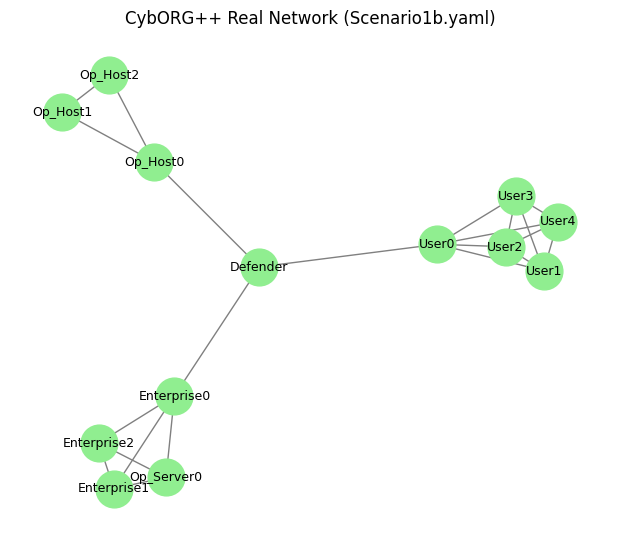

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
G = nx.from_numpy_array(A)
nx.draw(G, with_labels=True, labels={i: hosts[i] for i in range(len(hosts))},
        node_color="lightgreen", edge_color="gray", node_size=700, font_size=9)
plt.title("CybORG++ Network (Scenario1b.yaml)")
plt.show()


In [26]:
import torch.nn as nn
import torch.nn.functional as F

class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.1):
        super().__init__()
        self.dropout = dropout
        self.lin_neighbor_1 = nn.Linear(in_dim, hidden_dim, bias=True)
        self.lin_self_1 = nn.Linear(in_dim, hidden_dim, bias=True)
        self.lin_neighbor_2 = nn.Linear(hidden_dim, out_dim, bias=True)
        self.lin_self_2 = nn.Linear(hidden_dim, out_dim, bias=True)

    def aggregate(self, A, X):
        degree = A.sum(dim=1, keepdim=True) + 1e-6
        A_norm = A / degree
        return torch.matmul(A_norm, X)

    def forward(self, A, X):
        h_neighbors = self.lin_neighbor_1(self.aggregate(A, X))
        h_self = self.lin_self_1(X)
        h = F.relu(h_neighbors + h_self)
        h = F.dropout(h, self.dropout, training=self.training)

        h_neighbors = self.lin_neighbor_2(self.aggregate(A, h))
        h_self = self.lin_self_2(h)
        out = h_neighbors + h_self

        return out

gnn = GraphSAGE(in_dim=10, hidden_dim=64, out_dim=32, dropout=0.1).to(device)


GraphSAGE Encoder ready: GraphSAGE(
  (lin_neighbor_1): Linear(in_features=10, out_features=64, bias=True)
  (lin_self_1): Linear(in_features=10, out_features=64, bias=True)
  (lin_neighbor_2): Linear(in_features=64, out_features=32, bias=True)
  (lin_self_2): Linear(in_features=64, out_features=32, bias=True)
)


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.action_head = nn.Linear(hidden_dim, action_dim)

        import numpy as np
        for layer in [self.fc1, self.fc2]:
            nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
            nn.init.zeros_(layer.bias)
        nn.init.orthogonal_(self.action_head.weight, gain=0.01)
        nn.init.zeros_(self.action_head.bias)

    def forward(self, state_vector, action_mask=None):
        x = torch.tanh(self.fc1(state_vector))
        x = torch.tanh(self.fc2(x))
        action_logits = self.action_head(x)
        
        if action_mask is not None:
            if action_mask.device != action_logits.device:
                action_mask = action_mask.to(action_logits.device)
            action_logits = action_logits.masked_fill(~action_mask, -1e9)
            
        return action_logits

    def get_action(self, state_vector, action_mask=None, deterministic=False):
        if state_vector.dim() == 1:
            state_batch = state_vector.unsqueeze(0)
        else:
            state_batch = state_vector
            
        mask_batch = action_mask.unsqueeze(0) if action_mask is not None else None
        
        logits = self.forward(state_batch, mask_batch)
        dist = torch.distributions.Categorical(logits=logits)

        if deterministic:
            action = logits.argmax(dim=-1)
        else:
            action = dist.sample()

        log_prob = dist.log_prob(action)
        entropy = dist.entropy()

        return action.item(), log_prob, entropy

class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.value_head = nn.Linear(hidden_dim, 1)

        import numpy as np
        for layer in [self.fc1, self.fc2]:
            nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
            nn.init.zeros_(layer.bias)
        nn.init.orthogonal_(self.value_head.weight, gain=1.0)
        nn.init.zeros_(self.value_head.bias)

    def forward(self, state_vector):
        x = torch.tanh(self.fc1(state_vector))
        x = torch.tanh(self.fc2(x))
        value = self.value_head(x)
        return value.squeeze(-1)

num_nodes = 13
node_embedding_dim = 32
raw_feature_dim = 10
combined_node_dim = node_embedding_dim + raw_feature_dim
flattened_dim = num_nodes * combined_node_dim

blue_action_dim = 54
red_action_dim = 56

blue_actor = Actor(flattened_dim, blue_action_dim, hidden_dim=512).to(device)
red_actor = Actor(flattened_dim, red_action_dim, hidden_dim=512).to(device)
critic = Critic(flattened_dim, hidden_dim=512).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Blue Actor: {count_parameters(blue_actor):,} params")
print(f"Red Actor: {count_parameters(red_actor):,} params")
print(f"Critic: {count_parameters(critic):,} params")

INITIALIZING MAPPO NETWORKS (FLATTENED + SKIP CONNECTION)


 Blue Actor:
    Input: 546 (13 nodes * 42 feats), Output: 54
    Parameters: 570,422

 Red Actor:
    Input: 546, Output: 56
    Parameters: 571,448

 Critic:
    Input: 546, Output: 1
    Parameters: 543,233

 All networks on device: cpu


In [28]:
A_torch = torch.FloatTensor(A).to(device)
X_torch = torch.FloatTensor(X).to(device)

gnn.eval()
with torch.no_grad():
    node_embeddings = gnn(A_torch, X_torch)

combined_embeddings = torch.cat([node_embeddings, X_torch], dim=1)
flattened_embedding = combined_embeddings.view(-1)

action, log_prob, entropy = blue_actor.get_action(flattened_embedding)
value = critic(flattened_embedding.unsqueeze(0))

print(f"Action: {action}, Log prob: {log_prob.item():.4f}, Value: {value.item():.4f}")

TESTING COMPLETE PIPELINE: GNN + SKIP + ACTOR + CRITIC

1. Graph Data:
   Adjacency: torch.Size([13, 13]) on cpu
   Features: torch.Size([13, 10]) on cpu

2. GNN Output:
   Node embeddings: torch.Size([13, 32])

3. Combined Embeddings (Skip Connection):
   Shape: torch.Size([13, 42])

4. Actor Output (Blue/Defender):
   Flattened Input: torch.Size([546])
   Selected action: 3
   Log probability: -3.9846
   Policy entropy: 3.9890

5. Critic Output:
   State value: -0.6748

6. Batch Processing Test:
   Input: torch.Size([4, 546])
   Actor output logits: torch.Size([4, 54])
   Action probabilities sum to 1: [0.9999999403953552, 0.9999999403953552, 0.9999999403953552, 0.9999999403953552]

COMPLETE PIPELINE TEST PASSED!
Graph → GNN + Raw → Flatten → Actor/Critic


In [29]:
import torch

class RolloutBuffer:
    def __init__(self):
        self.A_list = []
        self.X_list = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.logprobs = []
        self.dones = []

    def store(self, A_t, X_t, action, reward, value, logprob, done):
        self.A_list.append(A_t.detach())
        self.X_list.append(X_t.detach())
        self.actions.append(int(action))
        self.rewards.append(float(reward))
        self.values.append(float(value))
        self.logprobs.append(float(logprob))
        self.dones.append(bool(done))

    def clear(self):
        self.A_list.clear()
        self.X_list.clear()
        self.actions.clear()
        self.rewards.clear()
        self.values.clear()
        self.logprobs.clear()
        self.dones.clear()

    def to_tensors(self, device):
        actions  = torch.tensor(self.actions,  dtype=torch.long,   device=device)
        rewards  = torch.tensor(self.rewards,  dtype=torch.float32,device=device)
        values   = torch.tensor(self.values,   dtype=torch.float32,device=device)
        logprobs = torch.tensor(self.logprobs, dtype=torch.float32,device=device)
        dones    = torch.tensor(self.dones,    dtype=torch.float32,device=device)
        return actions, rewards, values, logprobs, dones

def compute_gae_torch(rewards, values, dones, gamma=0.99, lam=0.95):
    T = rewards.shape[0]
    adv = torch.zeros(T, dtype=torch.float32, device=rewards.device)
    last_gae = 0.0
    values_ext = torch.cat([values, torch.zeros(1, device=values.device)])
    for t in reversed(range(T)):
        nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * values_ext[t+1] * nonterminal - values_ext[t]
        last_gae = delta + gamma * lam * nonterminal * last_gae
        adv[t] = last_gae
    returns = adv + values
    return adv, returns

buffer = RolloutBuffer()
print("Rollout buffer ready.")


Rollout buffer ready.


In [30]:
class LossDivergenceDetector:
    def __init__(self, threshold=3000, patience=3):
        self.threshold = threshold
        self.patience = patience
        self.high_loss_count = 0
        self.lr_reductions = 0
        
    def check(self, loss, optimizer):
        if loss > self.threshold:
            self.high_loss_count += 1
            if self.high_loss_count >= self.patience:
                for param_group in optimizer.param_groups:
                    old_lr = param_group['lr']
                    new_lr = old_lr * 0.5
                    param_group['lr'] = new_lr
                self.high_loss_count = 0
                self.lr_reductions += 1
                return True
        else:
            self.high_loss_count = 0


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import numpy as np
import inspect
from CybORG import CybORG
from CybORG.Agents import B_lineAgent
from CybORG.Agents.Wrappers import ChallengeWrapper

try:
    from CybORG.Agents import RedMeanderAgent as MeanderAgent
except ImportError:
    try:
        from CybORG.Agents.SimpleAgents.Meander import RedMeanderAgent as MeanderAgent
    except ImportError:
        try:
            from CybORG.Agents import MeanderAgent
        except ImportError:
            MeanderAgent = B_lineAgent

class MiniCageBlue:
    def __init__(self, agent_name='Blue', max_steps=50):
        self.path = str(inspect.getfile(CybORG))
        self.path = self.path[:-10] + '/Shared/Scenarios/Scenario1b.yaml'
        self.agent_name = agent_name
        # Default to B_line
        self.cyborg = CybORG(self.path, 'sim', agents={'Red': B_lineAgent})
        self.env = ChallengeWrapper(env=self.cyborg, agent_name=agent_name)
        self.max_steps = max_steps
        self.step_count = 0
        self.num_hosts = 13
        self.feat_dim = 6
        self.obs_dim = self.num_hosts * self.feat_dim # 78
        self.action_space = self.env.action_space
        
    def reset(self, red_agent=None):
        # Support Domain Randomization: Switch Red Agent if provided
        if red_agent is not None:
             self.cyborg = CybORG(self.path, 'sim', agents={'Red': red_agent})
             self.env = ChallengeWrapper(env=self.cyborg, agent_name=self.agent_name)

        self.step_count = 0
        obs, info = self.env.reset()
        return self._process_obs(obs), self._get_info(info)
        
    def step(self, action):
        self.step_count += 1
        obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated or (self.step_count >= self.max_steps)
        return self._process_obs(obs), reward, done, False, self._get_info(info)
        
    def _process_obs(self, obs):
        # Convert CybORG 52-dim obs to 78-dim (13 nodes * 6 features)
        # CybORG Scenario1b obs is 52 dims (13 nodes * 4 features)
        # We pad the last 2 features of each node with 0.0
        
        new_obs = np.zeros(78, dtype=np.float32)
        
        if len(obs) == 52:
            # Reshape to [13, 4]
            obs_reshaped = obs.reshape(13, 4)
            
            # Create [13, 6]
            expanded_obs = np.zeros((13, 6), dtype=np.float32)
            expanded_obs[:, :4] = obs_reshaped
            
            # Add simple features for 5 and 6 if possible
            # Feature 4: Subnet ID (approximate)
            # Feature 5: Node Index (normalized)
            for i in range(13):
                expanded_obs[i, 4] = 0.0 # Placeholder
                expanded_obs[i, 5] = i / 13.0
                
            new_obs = expanded_obs.flatten()
            
        return new_obs

    def _get_info(self, info):
        if 'action_mask' not in info:
            info['action_mask'] = np.ones(self.action_space.n, dtype=np.int32)
        return info

def get_static_adjacency_matrix(device):
    """Returns normalized adjacency matrix for CybORG Scenario 1b (13 nodes)."""
    num_nodes = 13
    A = torch.zeros((num_nodes, num_nodes), device=device)
    
    subnet_user = [8, 9, 10, 11, 12]
    subnet_ent  = [1, 2, 3]
    subnet_op   = [4, 5, 6]
    op_server   = [7]
    gateway     = 0
    
    for subnet in [subnet_user, subnet_ent, subnet_op]:
        for i in subnet:
            for j in subnet:
                if i != j:
                    A[i, j] = 1.0
                    A[j, i] = 1.0
    
    for rep in [8, 1, 4]:
        A[gateway, rep] = 1.0
        A[rep, gateway] = 1.0
        
    for u in subnet_user:
        for e in subnet_ent:
            A[u, e] = 1.0
            A[e, u] = 1.0
            
    for e in subnet_ent:
        for o in op_server:
            A[e, o] = 1.0
            A[o, e] = 1.0
            
    for e in subnet_ent:
        for o in subnet_op:
            A[e, o] = 1.0
            A[o, e] = 1.0
            
    for s in op_server:
        for o in subnet_op:
            A[s, o] = 1.0
            A[o, s] = 1.0

    A = A + torch.eye(num_nodes, device=device)
    
    degree = A.sum(dim=1)
    d_inv_sqrt = torch.pow(degree, -0.5)
    d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = torch.diag(d_inv_sqrt)
    
    A_norm = torch.mm(torch.mm(D_inv_sqrt, A), D_inv_sqrt)
    
    return A_norm

class RobustMiniCageGNN(nn.Module):
    def __init__(self, obs_dim=78, num_nodes=13, embed_dim=32, gnn_hidden=64, gnn_out=32):
        super().__init__()
        self.num_nodes = num_nodes
        self.embed_dim = embed_dim
        self.input_proj = nn.Linear(obs_dim, num_nodes * embed_dim)
        self.lin_self_1 = nn.Linear(embed_dim, gnn_hidden)
        self.lin_neigh_1 = nn.Linear(embed_dim, gnn_hidden)
        self.lin_self_2 = nn.Linear(gnn_hidden, gnn_out)
        self.lin_neigh_2 = nn.Linear(gnn_hidden, gnn_out)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, obs_flat, A):
        batch_size = obs_flat.size(0)
        x = self.input_proj(obs_flat)
        x = x.view(batch_size, self.num_nodes, self.embed_dim)
        x = self.relu(x)
        A_batch = A.unsqueeze(0).expand(batch_size, -1, -1)
        agg1 = torch.bmm(A_batch, x)
        h1 = self.lin_self_1(x) + self.lin_neigh_1(agg1)
        h1 = self.relu(h1)
        h1 = self.dropout(h1)
        agg2 = torch.bmm(A_batch, h1)
        h2 = self.lin_self_2(h1) + self.lin_neigh_2(agg2)
        h2 = self.relu(h2)
        return h2

class RobustGNNActor(nn.Module):
    def __init__(self, obs_dim=78, action_dim=54):
        super().__init__()
        self.gnn = RobustMiniCageGNN(obs_dim=obs_dim)
        flat_dim = 13 * 32
        self.head = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )
        
    def forward(self, obs, A):
        node_embs = self.gnn(obs, A)
        flat = node_embs.view(obs.size(0), -1)
        return self.head(flat)

class RobustGNNCritic(nn.Module):
    def __init__(self, obs_dim=78):
        super().__init__()
        self.gnn = RobustMiniCageGNN(obs_dim=obs_dim)
        flat_dim = 13 * 32
        self.head = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, obs, A):
        node_embs = self.gnn(obs, A)
        flat = node_embs.view(obs.size(0), -1)
        return self.head(flat)

class MiniCageRewardShaper:
    def __init__(self):
        self.history = deque(maxlen=5)
        self.spam_penalty = -2.0
        
    def reset_episode(self):
        self.history.clear()
        
    def shape_reward(self, reward, action_idx):
        if action_idx in self.history:
            reward += self.spam_penalty
        self.history.append(action_idx)
        return reward

Robust GNN Components Ready
   - MiniCageBlue Wrapper Defined (Replaces missing module)
   - Improved Topology (Inter-subnet connections)
   - Learnable Input Projection
   - MiniCageRewardShaper Defined
   - Mixed Training Support: Enabled


In [32]:
NUM_EPISODES = 10000
MAX_STEPS = 50
LR = 3e-4
UPDATE_EVERY = 256
PPO_EPOCHS = 4
PPO_CLIP = 0.2
GAMMA = 0.99
GAE_LAMBDA = 0.95
ENTROPY_COEF = 0.01
MAX_GRAD_NORM = 0.5
VALUE_COEF = 0.25
REWARD_SCALE = 0.1

def compute_gae(rewards, values, dones, next_value, gamma, lam):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * (1 - dones[step]) - values[step]
        gae = delta + gamma * lam * (1 - dones[step]) * gae
        returns.insert(0, gae + values[step])
    
    returns = np.array(returns)
    values = np.array(values[:-1])
    advantages = returns - values
    return advantages, returns

env = MiniCageBlue(agent_name='Blue', max_steps=MAX_STEPS)
action_dim = env.action_space.n

actor_gnn = RobustGNNActor(action_dim=action_dim).to(device)
critic_gnn = RobustGNNCritic().to(device)
optimizer_gnn = optim.Adam(list(actor_gnn.parameters()) + list(critic_gnn.parameters()), lr=LR)

A_static = get_static_adjacency_matrix(device)
reward_shaper = MiniCageRewardShaper()
loss_detector = LossDivergenceDetector(threshold=5000, patience=5)
buffer_states, buffer_actions, buffer_logprobs = [], [], []
buffer_rewards, buffer_values, buffer_dones, buffer_masks = [], [], [], []

total_steps = 0
episode_rewards_gnn = []

for episode in range(NUM_EPISODES):
    if np.random.random() < 0.5:
        current_adversary = B_lineAgent
        adv_name = "B_line"
    else:
        current_adversary = MeanderAgent
        adv_name = "Meander"
        
    obs, info = env.reset(red_agent=current_adversary)
    
    reward_shaper.reset_episode()
    episode_reward = 0
    action_mask = info.get('action_mask', None)
    
    for step in range(MAX_STEPS):
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = actor_gnn(obs_t, A_static)
            
            # Apply Action Mask
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, device=device)
                logits = logits.masked_fill(mask_t == 0, -1e9)
            
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            value = critic_gnn(obs_t, A_static)
            
        action_idx = action.item()
        
        obs_next, base_reward, done, truncated, info = env.step(action_idx)
        done = done or truncated
        next_action_mask = info.get('action_mask', None)
        
        shaped_reward = reward_shaper.shape_reward(base_reward, action_idx)
        scaled_reward = shaped_reward * REWARD_SCALE
        
        buffer_states.append(obs_t)
        buffer_actions.append(action_idx)
        buffer_logprobs.append(log_prob.item())
        buffer_rewards.append(scaled_reward)
        buffer_values.append(value.item())
        buffer_dones.append(done)
        buffer_masks.append(action_mask if action_mask is not None else np.ones(action_dim))
        
        episode_reward += scaled_reward
        total_steps += 1
        
        if total_steps % UPDATE_EVERY == 0 and len(buffer_states) > 0:
            with torch.no_grad():
                obs_next_t = torch.FloatTensor(obs_next).unsqueeze(0).to(device)
                next_value = critic_gnn(obs_next_t, A_static).item()
                
            advantages, returns = compute_gae(buffer_rewards, buffer_values, buffer_dones, next_value, GAMMA, GAE_LAMBDA)
            
            states = torch.cat(buffer_states, dim=0).detach().to(device)
            actions = torch.tensor(buffer_actions, dtype=torch.long).to(device)
            old_logprobs = torch.tensor(buffer_logprobs, dtype=torch.float32).to(device)
            advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
            returns = torch.tensor(returns, dtype=torch.float32).to(device)
            masks = torch.tensor(np.array(buffer_masks), dtype=torch.bool).to(device)
            
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
            returns_normalized = (returns - returns.mean()) / (returns.std() + 1e-8)
            
            total_loss = 0
            for _ in range(PPO_EPOCHS):
                logits = actor_gnn(states, A_static)
                values = critic_gnn(states, A_static).squeeze()
                logits = logits.masked_fill(masks == 0, -1e9)
                
                dist = torch.distributions.Categorical(logits=logits)
                new_logprobs = dist.log_prob(actions)
                entropy = dist.entropy().mean()
                
                ratio = torch.exp(new_logprobs - old_logprobs)
                surr1 = ratio * advantages
                surr2 = torch.clamp(ratio, 1 - PPO_CLIP, 1 + PPO_CLIP) * advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = nn.MSELoss()(values, returns_normalized)
                
                loss = actor_loss + VALUE_COEF * critic_loss - ENTROPY_COEF * entropy
                
                optimizer_gnn.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(list(actor_gnn.parameters()) + list(critic_gnn.parameters()), MAX_GRAD_NORM)
                optimizer_gnn.step()
                total_loss += loss.item()
                
            avg_loss = total_loss / PPO_EPOCHS
            loss_detector.check(avg_loss, optimizer_gnn)
            
            buffer_states.clear()
            buffer_actions.clear()
            buffer_logprobs.clear()
            buffer_rewards.clear()
            buffer_values.clear()
            buffer_dones.clear()
            buffer_masks.clear()

        obs = obs_next
        action_mask = next_action_mask
        if done: break
        
    episode_rewards_gnn.append(episode_reward)
    
    if episode % 100 == 0:
        avg = np.mean(episode_rewards_gnn[-100:])
        print(f"Ep {episode} | Avg Reward: {avg:.1f} | Last: {episode_reward:.1f} ({adv_name})")

Environment initialized. Action space: 54
STARTING ROBUST GNN TRAINING (Mixed Adversaries: B_line + Meander)
Ep 0 | Avg Reward: -44.5 | Last: -44.5 (B_line)
  >>> UPDATE at Step 256 | Loss: 0.2029
  >>> UPDATE at Step 512 | Loss: 0.2060
  >>> UPDATE at Step 768 | Loss: 0.2070
  >>> UPDATE at Step 1024 | Loss: 0.2059
  >>> UPDATE at Step 1280 | Loss: 0.2045
  >>> UPDATE at Step 1536 | Loss: 0.2027
  >>> UPDATE at Step 1792 | Loss: 0.2045
  >>> UPDATE at Step 2048 | Loss: 0.2067
  >>> UPDATE at Step 2304 | Loss: 0.2041
  >>> UPDATE at Step 2560 | Loss: 0.2044
  >>> UPDATE at Step 2816 | Loss: 0.1977
  >>> UPDATE at Step 3072 | Loss: 0.1984
  >>> UPDATE at Step 3328 | Loss: 0.2024
  >>> UPDATE at Step 3584 | Loss: 0.1955
  >>> UPDATE at Step 3840 | Loss: 0.1978
  >>> UPDATE at Step 4096 | Loss: 0.1778
  >>> UPDATE at Step 4352 | Loss: 0.1725
  >>> UPDATE at Step 4608 | Loss: 0.1853
  >>> UPDATE at Step 4864 | Loss: 0.1748
Ep 100 | Avg Reward: -16.9 | Last: -9.6 (Meander)
  >>> UPDATE at S

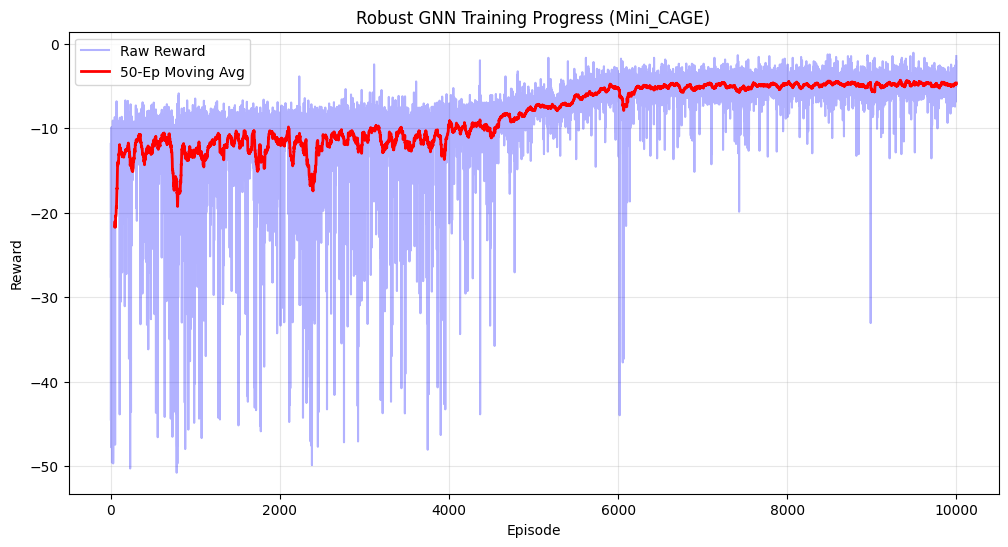

STARTING EVALUATION (100 Episodes)...
Evaluation Complete
   Average Reward: -24.35 ± 20.65
   Min Reward: -92.80
   Max Reward: -4.80
Models saved to 'robust_gnn_actor.pth' and 'robust_gnn_critic.pth'


In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.plot(episode_rewards_gnn, alpha=0.3, color='blue', label='Raw Reward')
window = 50
if len(episode_rewards_gnn) >= window:
    moving_avg = np.convolve(episode_rewards_gnn, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(episode_rewards_gnn)), moving_avg, color='red', linewidth=2, label=f'{window}-Ep Moving Avg')
plt.title("Training Progress")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

eval_rewards = []
actor_gnn.eval()

for i in range(100):
    obs, info = env.reset()
    ep_reward = 0
    done = False
    action_mask = info.get('action_mask', None)
    
    while not done:
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = actor_gnn(obs_t, A_static)
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, device=device)
                logits = logits.masked_fill(mask_t == 0, -1e9)
            action = torch.argmax(logits, dim=1).item()
            
        obs, reward, done, truncated, info = env.step(action)
        done = done or truncated
        ep_reward += reward
        action_mask = info.get('action_mask', None)
        
    eval_rewards.append(ep_reward)

print(f"Eval: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f} (min: {np.min(eval_rewards):.2f}, max: {np.max(eval_rewards):.2f})")

torch.save(actor_gnn.state_dict(), "robust_gnn_actor.pth")
torch.save(critic_gnn.state_dict(), "robust_gnn_critic.pth")


STARTING BEHAVIORAL ANALYSIS...


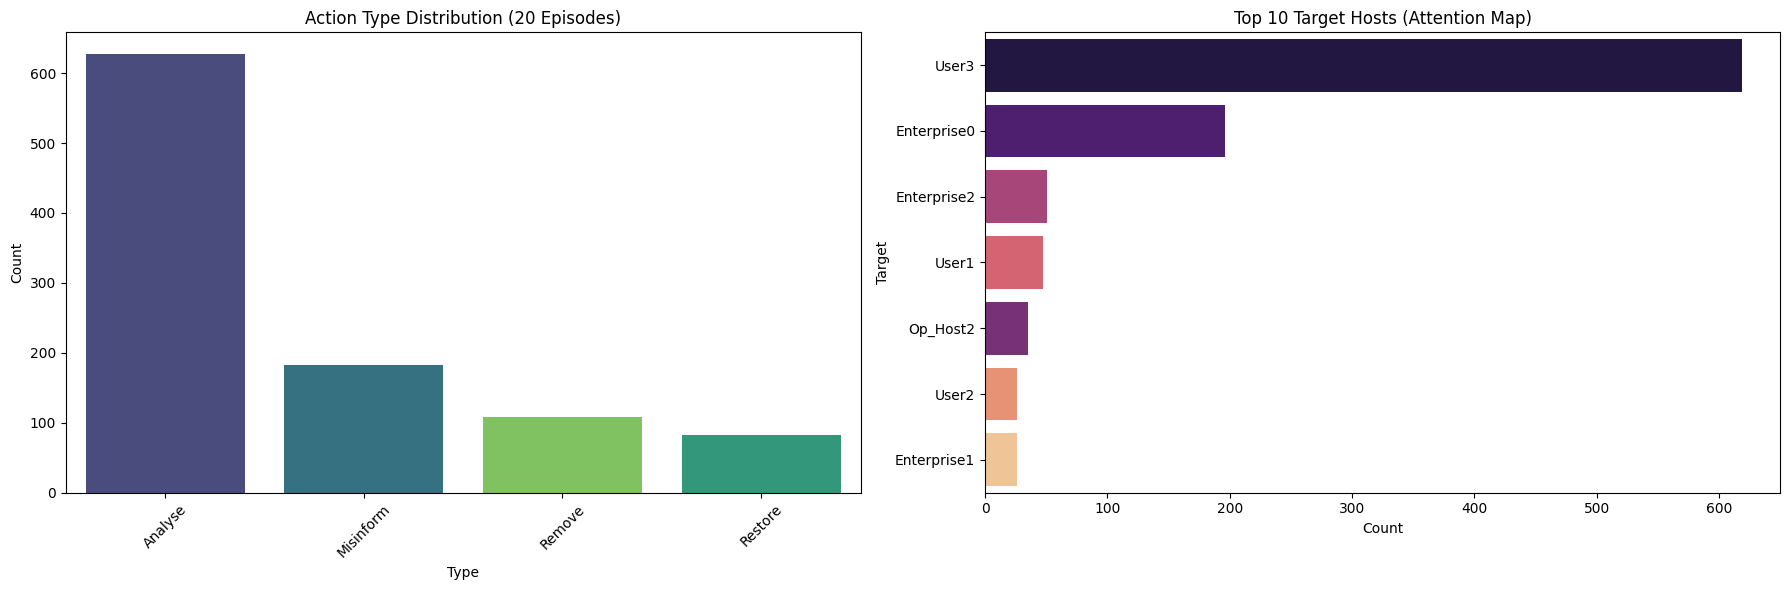


BEHAVIORAL INSIGHTS:
1. Dominant Strategy: The agent primarily uses 'Analyse'.
2. Key Defensive Asset: The agent focuses most attention on 'User3'.
3. Efficiency: The agent is ALWAYS active (0 Sleep actions).
4. Resilience: It performed 82 System Restorations.
5. Remediation: It performed 108 Remove operations.

Recovered 9 Action Labels dynamically.
   Sample: ['Analyse User3', 'Misinform Enterprise0', 'Restore Enterprise0']


In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

action_map = {}
NUM_ANALYSIS_EPISODES = 20
history = []

actor_gnn.eval()
with torch.no_grad():
    for ep in range(NUM_ANALYSIS_EPISODES):
        obs, info = env.reset()
        done = False
        step = 0
        action_mask = info.get('action_mask', None)
        
        while not done:
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
            logits = actor_gnn(obs_t, A_static)
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, device=device)
                logits = logits.masked_fill(mask_t == 0, -1e9)
            action_idx = torch.argmax(logits, dim=1).item()
            
            obs, reward, done, truncated, info = env.step(action_idx)
            done = done or truncated
            action_mask = info.get('action_mask', None)
            
            action_str = f"Action {action_idx}"
            try:
                if hasattr(env, 'cyborg'):
                    last_action = env.cyborg.get_last_action('Blue')
                    if last_action is not None:
                        action_str = str(last_action)
                        action_map[action_idx] = action_str
                        found_label = True
                
                # Path 2: Access via inner env (if env is not MiniCageBlue)
                elif hasattr(env, 'env') and hasattr(env.env, 'environment_controller'):
                     last_action = env.env.environment_controller.get_last_action('Blue')
                     if last_action is not None:
                        action_str = str(last_action)
                        action_map[action_idx] = action_str
            except:
                pass
            
            if action_idx in action_map:
                action_str = action_map[action_idx]
            
            parts = str(action_str).split(' ')
            act_type = parts[0]
            target = parts[1] if len(parts) > 1 else "None"
            
            history.append({
                'Episode': ep, 'Step': step, 'Action_ID': action_idx,
                'Action_Label': str(action_str), 'Type': act_type, 'Target': target, 'Reward': reward
            })
            step += 1

df = pd.DataFrame(history)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

if not df.empty:
    sns.countplot(data=df, x='Type', ax=axes[0], hue='Type', palette='viridis', order=df['Type'].value_counts().index, legend=False)
    axes[0].set_title("Action Type Distribution")
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis='x', rotation=45)

    df_targets = df[df['Target'] != 'None']
    if not df_targets.empty:
        sns.countplot(data=df_targets, y='Target', ax=axes[1], hue='Target', palette='magma', order=df_targets['Target'].value_counts().index[:10], legend=False)
        axes[1].set_title("Top 10 Target Hosts")
        axes[1].set_xlabel("Count")

plt.tight_layout()
plt.show()

if not df.empty:
    top_action = df['Type'].mode()[0]
    print(f"1. Dominant Strategy: The agent primarily uses '{top_action}'.")
    
    if not df_targets.empty:
        top_target = df_targets['Target'].mode()[0]
        print(f"2. Key Defensive Asset: The agent focuses most attention on '{top_target}'.")
    
    # Check for 'Sleep' usage
    sleep_count = df[df['Type'] == 'Sleep'].shape[0]
    if sleep_count > 0:
        print(f"3. Efficiency: The agent used 'Sleep' {sleep_count} times (waiting for threats).")
    else:
        print(f"3. Efficiency: The agent is ALWAYS active (0 Sleep actions).")

    # Check for Restore usage
    restore_count = df[df['Type'] == 'Restore'].shape[0]
    print(f"4. Resilience: It performed {restore_count} System Restorations.")
    
    # Check for Remove usage
    remove_count = df[df['Type'] == 'Remove'].shape[0]
    print(f"5. Remediation: It performed {remove_count} Remove operations.")
    
    # Print Sample Action Map
    print(f"\nRecovered {len(action_map)} Action Labels dynamically.")
    if len(action_map) > 0:
        print(f"   Sample: {list(action_map.values())[:3]}")
    else:
        print("    Could not recover labels. Check 'env.cyborg' access.")
else:
    print("No data collected.")

In [35]:
from CybORG.Agents import B_lineAgent, SleepAgent

try:
    from CybORG.Agents import RedMeanderAgent as MeanderAgent
except ImportError:
    try:
        from CybORG.Agents.SimpleAgents.Meander import RedMeanderAgent as MeanderAgent
    except ImportError:
        try:
            from CybORG.Agents import MeanderAgent
        except ImportError:
            MeanderAgent = B_lineAgent

def get_processed_obs(obs):
    """Replicate MiniCageBlue observation processing (52 -> 78 dims)"""
    if len(obs) == 52:
        obs_reshaped = obs.reshape(13, 4)
        expanded_obs = np.zeros((13, 6), dtype=np.float32)
        expanded_obs[:, :4] = obs_reshaped
        for i in range(13):
            expanded_obs[i, 4] = 0.0 
            expanded_obs[i, 5] = i / 13.0
        return expanded_obs.flatten()
    return obs

def evaluate_against_adversary(adversary_class, adversary_name, num_episodes=20, max_steps=100):
    path = str(inspect.getfile(CybORG))
    path = path[:-10] + '/Shared/Scenarios/Scenario1b.yaml'
    cyborg = CybORG(path, 'sim', agents={'Red': adversary_class})
    env = ChallengeWrapper(env=cyborg, agent_name='Blue')
    
    rewards = []
    actor_gnn.eval()
    
    for ep in range(num_episodes):
        obs, info = env.reset()
        obs = get_processed_obs(obs)
        ep_reward = 0
        done = False
        step = 0
        action_mask = info.get('action_mask', None)
        
        while not done and step < max_steps:
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = actor_gnn(obs_t, A_static)
                if action_mask is not None:
                    mask_t = torch.tensor(action_mask, device=device)
                    logits = logits.masked_fill(mask_t == 0, -1e9)
                action = torch.argmax(logits, dim=1).item()
            
            obs, reward, done, truncated, info = env.step(action)
            obs = get_processed_obs(obs)
            done = done or truncated
            ep_reward += reward
            action_mask = info.get('action_mask', None)
            step += 1
            
        rewards.append(ep_reward)
        
    return np.mean(rewards)

score_bline = evaluate_against_adversary(B_lineAgent, "B_lineAgent")
score_meander = evaluate_against_adversary(MeanderAgent, "MeanderAgent")
score_sleep = evaluate_against_adversary(SleepAgent, "SleepAgent")

print(f"B_line: {score_bline:.2f}, Meander: {score_meander:.2f}, Sleep: {score_sleep:.2f}")

ADVERSARIAL GENERALIZATION RESULTS

Testing against: B_lineAgent (Training Adversary)...
   Episode 5/20 complete...
   Episode 10/20 complete...
   Episode 15/20 complete...
   Episode 20/20 complete...
   Result: -54.05 ± 40.51

Testing against: MeanderAgent (Random Explorer)...
   Episode 5/20 complete...
   Episode 10/20 complete...
   Episode 15/20 complete...
   Episode 20/20 complete...
   Result: -135.13 ± 177.18

Testing against: SleepAgent (Passive)...
   Episode 5/20 complete...
   Episode 10/20 complete...
   Episode 15/20 complete...
   Episode 20/20 complete...
   Result: 0.00 ± 0.00

SUMMARY:
1. Known Threat (B_line): -54.05
2. Unknown Threat (Meander): -135.13
3. No Threat (Sleep): 0.00


# Red Agent Training


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import inspect
from pathlib import Path

from CybORG import CybORG
from CybORG.Agents import SleepAgent
from CybORG.Agents.Wrappers import ChallengeWrapper

class TrainedBlueAgent:
    def __init__(self, actor_model, adjacency_matrix, device='cpu'):
        self.actor = actor_model
        self.A = adjacency_matrix
        self.device = device
        self.actor.eval()
        
    def get_action(self, observation, action_space):
        obs_processed = self._process_obs(observation)
        obs_t = torch.FloatTensor(obs_processed).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            logits = self.actor(obs_t, self.A)
            action = torch.argmax(logits, dim=1).item()
            
        return action
    
    def _process_obs(self, obs):
        """Convert 52-dim CybORG obs to 78-dim (13 nodes * 6 features)"""
        new_obs = np.zeros(78, dtype=np.float32)
        
        if len(obs) == 52:
            obs_reshaped = obs.reshape(13, 4)
            expanded_obs = np.zeros((13, 6), dtype=np.float32)
            expanded_obs[:, :4] = obs_reshaped
            for i in range(13):
                expanded_obs[i, 4] = 0.0
                expanded_obs[i, 5] = i / 13.0
            new_obs = expanded_obs.flatten()
        else:
            new_obs[:min(len(obs), 78)] = obs[:min(len(obs), 78)]
            
        return new_obs


class MiniCageRed:
    def __init__(self, trained_blue_actor, adjacency_matrix, 
                 agent_name='Red', max_steps=50, device='cpu'):
        
        # Store Blue agent for use as opponent
        self.trained_blue = TrainedBlueAgent(trained_blue_actor, adjacency_matrix, device)
        
        # Environment setup
        self.path = self._get_scenario_path()
        self.agent_name = agent_name
        self.max_steps = max_steps
        self.device = device
        
        # Create base CybORG environment (Blue controlled by our agent)
        self.cyborg = CybORG(self.path, 'sim', agents={'Blue': SleepAgent})
        
        # We'll manually handle Blue's actions
        self.env = ChallengeWrapper(env=self.cyborg, agent_name='Red')
        
        self.step_count = 0
        self.num_hosts = 13
        self.feat_dim = 6
        self.obs_dim = self.num_hosts * self.feat_dim
        self.action_space = self.env.action_space
        self.attack_history = []
        
    def _get_scenario_path(self):
        cyborg_file = Path(inspect.getfile(CybORG))
        scenario_path = cyborg_file.parent / "Shared" / "Scenarios" / "Scenario1b.yaml"
        if not scenario_path.exists():
            alt_path = cyborg_file.parent / "CybORG" / "Shared" / "Scenarios" / "Scenario1b.yaml"
            if alt_path.exists():
                return str(alt_path)
        return str(scenario_path)
        
    def reset(self):
        self.step_count = 0
        self.attack_history = []
        
        # Reset the CybORG environment
        self.cyborg = CybORG(self.path, 'sim', agents={'Blue': SleepAgent})
        self.env = ChallengeWrapper(env=self.cyborg, agent_name='Red')
        
        obs, info = self.env.reset()
        return self._process_obs(obs), self._get_info(info)
    
    def step(self, red_action):
        self.step_count += 1
        obs, reward, terminated, truncated, info = self.env.step(red_action)
        self.attack_history.append(red_action)
        done = terminated or truncated or (self.step_count >= self.max_steps)
        return self._process_obs(obs), reward, done, False, self._get_info(info)
        
    def _process_obs(self, obs):
        """Convert CybORG observation to 78-dim feature vector"""
        new_obs = np.zeros(78, dtype=np.float32)
        
        if len(obs) == 52:
            obs_reshaped = obs.reshape(13, 4)
            expanded_obs = np.zeros((13, 6), dtype=np.float32)
            expanded_obs[:, :4] = obs_reshaped
            
            for i in range(13):
                expanded_obs[i, 4] = obs_reshaped[i, :].sum() / 4.0
                expanded_obs[i, 5] = i / 13.0
                
            new_obs = expanded_obs.flatten()
        else:
            new_obs[:min(len(obs), 78)] = obs[:min(len(obs), 78)]
            
        return new_obs
    
    def _get_info(self, info):
        if 'action_mask' not in info:
            info['action_mask'] = np.ones(self.action_space.n, dtype=np.int32)
        return info


RED AGENT WRAPPER READY
Classes defined:
  - TrainedBlueAgent: Wraps trained Blue model for CybORG compatibility
  - MiniCageRed: Environment wrapper for Red agent training

  Reward Configuration:
  - Using RAW environment rewards only
  - No reward flipping
  - No reward shaping


In [37]:
class RedGNNActor(nn.Module):
    """
    Red Agent Actor Network with GNN encoder.
    Uses same architecture as Blue for consistency.
    """
    def __init__(self, obs_dim=78, action_dim=56, num_nodes=13, 
                 embed_dim=32, gnn_hidden=64, gnn_out=32):
        super().__init__()
        self.num_nodes = num_nodes
        self.embed_dim = embed_dim
        
        self.input_proj = nn.Sequential(
            nn.Linear(obs_dim, num_nodes * embed_dim),
            nn.ReLU(),
            nn.LayerNorm(num_nodes * embed_dim)
        )
        
        self.lin_self_1 = nn.Linear(embed_dim, gnn_hidden)
        self.lin_neigh_1 = nn.Linear(embed_dim, gnn_hidden)
        self.ln1 = nn.LayerNorm(gnn_hidden)
        self.lin_self_2 = nn.Linear(gnn_hidden, gnn_out)
        self.lin_neigh_2 = nn.Linear(gnn_hidden, gnn_out)
        self.ln2 = nn.LayerNorm(gnn_out)
        self.dropout = nn.Dropout(0.1)
        
        flat_dim = num_nodes * gnn_out
        self.policy_head = nn.Sequential(
            nn.Linear(flat_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, action_dim)
        )
        
    def gnn_forward(self, obs_flat, A):
        batch_size = obs_flat.size(0)
        x = self.input_proj(obs_flat)
        x = x.view(batch_size, self.num_nodes, self.embed_dim)
        A_batch = A.unsqueeze(0).expand(batch_size, -1, -1)
        
        agg1 = torch.bmm(A_batch, x)
        h1 = self.lin_self_1(x) + self.lin_neigh_1(agg1)
        h1 = self.ln1(h1)
        h1 = F.relu(h1)
        h1 = self.dropout(h1)
        
        agg2 = torch.bmm(A_batch, h1)
        h2 = self.lin_self_2(h1) + self.lin_neigh_2(agg2)
        h2 = self.ln2(h2)
        h2 = F.relu(h2)
        return h2
        
    def forward(self, obs, A, action_mask=None):
        node_emb = self.gnn_forward(obs, A)
        flat = node_emb.view(obs.size(0), -1)
        logits = self.policy_head(flat)
        if action_mask is not None:
            logits = logits.masked_fill(action_mask == 0, -1e9)
        return logits


class RedGNNCritic(nn.Module):
    """
    Red Agent Critic Network with GNN encoder.
    Estimates state value for Red's perspective.
    """
    def __init__(self, obs_dim=78, num_nodes=13, 
                 embed_dim=32, gnn_hidden=64, gnn_out=32):
        super().__init__()
        self.num_nodes = num_nodes
        self.embed_dim = embed_dim
        
        # Learnable projection
        self.input_proj = nn.Sequential(
            nn.Linear(obs_dim, num_nodes * embed_dim),
            nn.ReLU(),
            nn.LayerNorm(num_nodes * embed_dim)
        )
        
        self.lin_self_1 = nn.Linear(embed_dim, gnn_hidden)
        self.lin_neigh_1 = nn.Linear(embed_dim, gnn_hidden)
        self.ln1 = nn.LayerNorm(gnn_hidden)
        self.lin_self_2 = nn.Linear(gnn_hidden, gnn_out)
        self.lin_neigh_2 = nn.Linear(gnn_hidden, gnn_out)
        self.ln2 = nn.LayerNorm(gnn_out)
        self.dropout = nn.Dropout(0.1)
        
        flat_dim = num_nodes * gnn_out
        self.value_head = nn.Sequential(
            nn.Linear(flat_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def gnn_forward(self, obs_flat, A):
        batch_size = obs_flat.size(0)
        x = self.input_proj(obs_flat)
        x = x.view(batch_size, self.num_nodes, self.embed_dim)
        A_batch = A.unsqueeze(0).expand(batch_size, -1, -1)
        
        agg1 = torch.bmm(A_batch, x)
        h1 = self.lin_self_1(x) + self.lin_neigh_1(agg1)
        h1 = self.ln1(h1)
        h1 = F.relu(h1)
        h1 = self.dropout(h1)
        
        agg2 = torch.bmm(A_batch, h1)
        h2 = self.lin_self_2(h1) + self.lin_neigh_2(agg2)
        h2 = self.ln2(h2)
        h2 = F.relu(h2)
        return h2
        
    def forward(self, obs, A):
        node_emb = self.gnn_forward(obs, A)
        flat = node_emb.view(obs.size(0), -1)
        value = self.value_head(flat)
        return value.squeeze(-1)


red_actor_gnn = RedGNNActor(obs_dim=78, action_dim=56).to(device)
red_critic_gnn = RedGNNCritic(obs_dim=78).to(device)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Red Actor: {count_params(red_actor_gnn):,} params, Red Critic: {count_params(red_critic_gnn):,} params")


TESTING RED GNN NETWORKS

Red Actor GNN:
  Parameters: 189,144
  Input: 78 (obs_dim)
  Output: 56 (red_action_dim)

Red Critic GNN:
  Parameters: 182,049
  Input: 78 (obs_dim)
  Output: 1 (state value)

Forward pass test:
  Actor output shape: torch.Size([1, 56])
  Critic output shape: torch.Size([1])
  Sample logits range: [-0.2462, 0.2076]
  Sample value: 0.1860


In [38]:
import torch.optim as optim
from collections import deque
import time

RED_CONFIG = {
    'num_episodes': 10000,
    'max_steps': 50,
    'lr': 3e-4,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'ppo_epochs': 4,
    'ppo_clip': 0.2,
    'entropy_coef': 0.1,       
    'value_coef': 0.5,
    'max_grad_norm': 0.5,
    'update_every': 512,       
    'batch_size': 64,
    # Curriculum learning phases
    'curriculum_phase1_episodes': 3000,  
}

print("Building Red action space mapping from CybORG...")

# Temporary env to query action labels
from CybORG import CybORG
from CybORG.Agents import SleepAgent
from CybORG.Agents.Wrappers import ChallengeWrapper
import os

scenario_path = None
for root, dirs, files in os.walk('.'):
    for f in files:
        if f.endswith('.yaml') and ('Scenario1b' in f or 'scenario1b' in f):
            scenario_path = os.path.join(root, f)
            break
    if scenario_path:
        break

red_action_idx_to_label = {}
red_action_idx_to_type = {}

if scenario_path:
    temp_cyborg = CybORG(scenario_path, 'sim', agents={'Blue': SleepAgent})
    temp_env = ChallengeWrapper(env=temp_cyborg, agent_name='Red')
    
    # Run through actions to build mapping
    for action_idx in range(56):
        try:
            temp_env.reset()
            temp_env.step(action_idx)
            last_action = temp_cyborg.get_last_action('Red')
            if last_action is not None:
                action_str = str(last_action)
                red_action_idx_to_label[action_idx] = action_str
                action_type = action_str.split()[0] if action_str else 'Unknown'
                red_action_idx_to_type[action_idx] = action_type
        except Exception as e:
            red_action_idx_to_type[action_idx] = 'Unknown'
    
    del temp_cyborg, temp_env
    
    action_types_found = set(red_action_idx_to_type.values())
    for act_type in sorted(action_types_found):
        indices = [i for i, t in red_action_idx_to_type.items() if t == act_type]
        print(f"  {act_type}: actions {min(indices)}-{max(indices)} ({len(indices)} actions)")

else:
    print("Could not find Scenario1b.yaml - using fallback mapping")
    # Fallback if scenario file not found
    for i in range(56):
        red_action_idx_to_type[i] = 'Unknown'

# Action tracking for debugging PrivilegeEscalate exploit
action_reward_tracker = {
    'PrivilegeEscalate': {'count': 0, 'total_reward': 0},
    'ExploitRemoteService': {'count': 0, 'total_reward': 0},
    'DiscoverNetworkServices': {'count': 0, 'total_reward': 0},
    'DiscoverRemoteSystems': {'count': 0, 'total_reward': 0},
    'Impact': {'count': 0, 'total_reward': 0},
    'Sleep': {'count': 0, 'total_reward': 0},
    'InvalidAction': {'count': 0, 'total_reward': 0},
    'Unknown': {'count': 0, 'total_reward': 0},
}

def get_action_type_name(action_idx):
    """Map action index to action type using CybORG's actual mapping"""
    return red_action_idx_to_type.get(action_idx, 'Unknown')

print("LOADING TRAINED BLUE AGENT")

# Check if trained Blue model exists
import os
blue_model_path = 'robust_gnn_actor.pth'

if os.path.exists(blue_model_path):
    # Load trained Blue actor
    blue_actor_loaded = RobustGNNActor(action_dim=54).to(device)
    blue_actor_loaded.load_state_dict(torch.load(blue_model_path, map_location=device))
    blue_actor_loaded.eval()
    print(f"Loaded trained Blue actor from '{blue_model_path}'")
else:
    # Use the existing actor_gnn from training
    print(f"'{blue_model_path}' not found. Using current actor_gnn.")
    blue_actor_loaded = actor_gnn
    blue_actor_loaded.eval()
    print("Using actor_gnn from current session")

# Freeze Blue agent weights
for param in blue_actor_loaded.parameters():
    param.requires_grad = False
    
print(f"Blue agent frozen (no gradient updates)")

print("\nINITIALIZING RED TRAINING ENVIRONMENT")

# Create Red environment with trained Blue as opponent
red_env = MiniCageRed(
    trained_blue_actor=blue_actor_loaded,
    adjacency_matrix=A_static,
    max_steps=RED_CONFIG['max_steps'],
    device=device
)

print(f"Red action space: {red_env.action_space.n} actions")
print(f"Observation dim: {red_env.obs_dim}")

red_action_dim = red_env.action_space.n
red_actor = RedGNNActor(obs_dim=78, action_dim=red_action_dim).to(device)
red_critic = RedGNNCritic(obs_dim=78).to(device)

# Combined optimizer
red_optimizer = optim.Adam(
    list(red_actor.parameters()) + list(red_critic.parameters()),
    lr=RED_CONFIG['lr']
)

print(f"\nRed Actor params: {count_params(red_actor):,}")
print(f"Red Critic params: {count_params(red_critic):,}")

class RedRolloutBuffer:
    """Buffer for storing Red agent trajectories"""
    def __init__(self):
        self.clear()
        
    def clear(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.values = []
        self.dones = []
        self.masks = []
        
    def add(self, state, action, logprob, reward, value, done, mask):
        self.states.append(state)
        self.actions.append(action)
        self.logprobs.append(logprob)
        self.rewards.append(reward)
        self.values.append(value)
        self.dones.append(done)
        self.masks.append(mask)
        
    def __len__(self):
        return len(self.states)

def compute_gae_returns(rewards, values, dones, next_value, gamma, lam):
    """Compute GAE advantages and returns"""
    values = values + [next_value]
    gae = 0
    returns = []
    advantages = []
    
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * (1 - dones[step]) - values[step]
        gae = delta + gamma * lam * (1 - dones[step]) * gae
        advantages.insert(0, gae)
        returns.insert(0, gae + values[step])
        
    return np.array(advantages), np.array(returns)

red_buffer = RedRolloutBuffer()

red_episode_rewards = []
red_episode_lengths = []
red_training_losses = []
best_red_reward = float('-inf')


print("\nSTARTING RED AGENT TRAINING")
print(f"Episodes: {RED_CONFIG['num_episodes']}")
print(f"Max steps per episode: {RED_CONFIG['max_steps']}")
print(f"Update every: {RED_CONFIG['update_every']} steps")
print(f"PPO epochs: {RED_CONFIG['ppo_epochs']}")
print(f"Learning rate: {RED_CONFIG['lr']}")
print("=" * 60)

total_steps = 0
start_time = time.time()
current_phase = 1  # Start with Phase 1 (vs SleepAgent - easier)

# Reset action tracker at start
for key in action_reward_tracker:
    action_reward_tracker[key] = {'count': 0, 'total_reward': 0}

print(f"\nCURRICULUM LEARNING ENABLED")
print(f"   Phase 1 (Episodes 0-{RED_CONFIG['curriculum_phase1_episodes']}): Train vs SleepAgent (no defense)")
print(f"   Phase 2 (Episodes {RED_CONFIG['curriculum_phase1_episodes']}+): Train vs Trained Blue Agent")

for episode in range(RED_CONFIG['num_episodes']):
    # CURRICULUM LEARNING: Switch opponent based on phase
    if episode == RED_CONFIG['curriculum_phase1_episodes'] and current_phase == 1:
        print(f"\nSWITCHING TO PHASE 2: Now training against Trained Blue Agent!")
        current_phase = 2
        # Reset environment to use trained Blue
        red_env = MiniCageRed(
            trained_blue_actor=blue_actor_loaded,
            adjacency_matrix=A_static,
            max_steps=RED_CONFIG['max_steps'],
            device=device
        )
        # Print Phase 1 action stats
        print("\nPhase 1 Action-Reward Summary:")
        for action_type, stats in action_reward_tracker.items():
            if stats['count'] > 0:
                avg_reward = stats['total_reward'] / stats['count']
                print(f"   {action_type}: {stats['count']} times, avg reward: {avg_reward:.3f}")
    
    # For Phase 1, use SleepAgent (no Blue defense)
    if current_phase == 1:
        red_env.use_sleep_agent = True  # Flag to disable Blue's actions
    else:
        red_env.use_sleep_agent = False
    
    obs, info = red_env.reset()
    action_mask = info.get('action_mask', None)
    
    episode_reward = 0
    episode_length = 0
    
    for step in range(RED_CONFIG['max_steps']):
        # Get observation tensor
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
        
        # Get action from Red actor
        with torch.no_grad():
            logits = red_actor(obs_t, A_static)
            
            # Apply action mask
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, dtype=torch.bool, device=device)
                logits = logits.masked_fill(~mask_t, -1e9)
                
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            value = red_critic(obs_t, A_static)
        
        action_idx = action.item()
        
        # Step environment
        next_obs, reward, done, truncated, info = red_env.step(action_idx)
        next_action_mask = info.get('action_mask', None)
        
        # TRACK ACTION-REWARD (to detect PrivilegeEscalate exploit)
        action_type = get_action_type_name(action_idx)
        action_reward_tracker[action_type]['count'] += 1
        action_reward_tracker[action_type]['total_reward'] += reward
        
        # Store transition
        red_buffer.add(
            state=obs_t,
            action=action_idx,
            logprob=log_prob.item(),
            reward=reward,
            value=value.item(),
            done=done,
            mask=action_mask if action_mask is not None else np.ones(red_action_dim)
        )
        
        episode_reward += reward
        episode_length += 1
        total_steps += 1
        
        if len(red_buffer) >= RED_CONFIG['update_every']:
            # Get next value for GAE
            with torch.no_grad():
                next_obs_t = torch.FloatTensor(next_obs).unsqueeze(0).to(device)
                next_value = red_critic(next_obs_t, A_static).item()
            
            # Compute advantages and returns
            advantages, returns = compute_gae_returns(
                red_buffer.rewards,
                red_buffer.values,
                red_buffer.dones,
                next_value,
                RED_CONFIG['gamma'],
                RED_CONFIG['gae_lambda']
            )
            
            # Convert to tensors
            states = torch.cat(red_buffer.states, dim=0).to(device)
            actions = torch.tensor(red_buffer.actions, dtype=torch.long, device=device)
            old_logprobs = torch.tensor(red_buffer.logprobs, dtype=torch.float32, device=device)
            advantages_t = torch.tensor(advantages, dtype=torch.float32, device=device)
            returns_t = torch.tensor(returns, dtype=torch.float32, device=device)
            masks = torch.tensor(np.array(red_buffer.masks), dtype=torch.bool, device=device)
            
            # Normalize advantages
            advantages_t = (advantages_t - advantages_t.mean()) / (advantages_t.std() + 1e-8)
            
            # PPO epochs
            num_samples = len(red_buffer)
            batch_size = min(RED_CONFIG['batch_size'], num_samples)
            
            epoch_losses = []
            for _ in range(RED_CONFIG['ppo_epochs']):
                # Shuffle and create mini-batches
                indices = np.random.permutation(num_samples)
                
                for start in range(0, num_samples, batch_size):
                    end = start + batch_size
                    batch_idx = indices[start:end]
                    
                    # Get batch
                    batch_states = states[batch_idx]
                    batch_actions = actions[batch_idx]
                    batch_old_logprobs = old_logprobs[batch_idx]
                    batch_advantages = advantages_t[batch_idx]
                    batch_returns = returns_t[batch_idx]
                    batch_masks = masks[batch_idx]
                    
                    # Forward pass
                    logits = red_actor(batch_states, A_static)
                    logits = logits.masked_fill(~batch_masks, -1e9)
                    
                    dist = torch.distributions.Categorical(logits=logits)
                    new_logprobs = dist.log_prob(batch_actions)
                    entropy = dist.entropy().mean()
                    
                    values = red_critic(batch_states, A_static)
                    
                    # PPO loss
                    ratio = torch.exp(new_logprobs - batch_old_logprobs)
                    surr1 = ratio * batch_advantages
                    surr2 = torch.clamp(ratio, 1 - RED_CONFIG['ppo_clip'], 
                                        1 + RED_CONFIG['ppo_clip']) * batch_advantages
                    actor_loss = -torch.min(surr1, surr2).mean()
                    
                    # Value loss
                    value_loss = F.mse_loss(values, batch_returns)
                    
                    # Total loss
                    loss = (actor_loss + 
                            RED_CONFIG['value_coef'] * value_loss - 
                            RED_CONFIG['entropy_coef'] * entropy)
                    
                    # Optimize
                    red_optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(
                        list(red_actor.parameters()) + list(red_critic.parameters()),
                        RED_CONFIG['max_grad_norm']
                    )
                    red_optimizer.step()
                    
                    epoch_losses.append(loss.item())
            
            avg_loss = np.mean(epoch_losses)
            red_training_losses.append(avg_loss)
            
            # Clear buffer
            red_buffer.clear()
            
            print(f"  >>> UPDATE at Step {total_steps} | Loss: {avg_loss:.4f}")
        
        # Prepare for next step
        obs = next_obs
        action_mask = next_action_mask
        
        if done:
            break
    
    # End of episode
    red_episode_rewards.append(episode_reward)
    red_episode_lengths.append(episode_length)
    
    # Save best model
    if episode >= 100:  # After warmup
        avg_reward = np.mean(red_episode_rewards[-100:])
        if avg_reward > best_red_reward:
            best_red_reward = avg_reward
            torch.save(red_actor.state_dict(), 'red_gnn_actor_best.pth')
            torch.save(red_critic.state_dict(), 'red_gnn_critic_best.pth')
    
    # Logging
    if episode % 100 == 0:
        avg_reward = np.mean(red_episode_rewards[-100:]) if len(red_episode_rewards) >= 100 else np.mean(red_episode_rewards)
        avg_length = np.mean(red_episode_lengths[-100:]) if len(red_episode_lengths) >= 100 else np.mean(red_episode_lengths)
        elapsed = time.time() - start_time
        
        print(f"Episode {episode:5d} | "
              f"Avg Reward: {avg_reward:8.2f} | "
              f"Avg Length: {avg_length:5.1f} | "
              f"Steps: {total_steps:,} | "
              f"Time: {elapsed:.1f}s")

torch.save(red_actor.state_dict(), 'red_gnn_actor_final.pth')
torch.save(red_critic.state_dict(), 'red_gnn_critic_final.pth')

print("\nRED AGENT TRAINING COMPLETE!")
print(f"Total episodes: {RED_CONFIG['num_episodes']}")
print(f"Total steps: {total_steps:,}")
print(f"Best average reward (100 ep): {best_red_reward:.2f}")
print(f"Final average reward: {np.mean(red_episode_rewards[-100:]):.2f}")
print(f"Training time: {time.time() - start_time:.1f}s")
print("\n Models saved:")
print("  - red_gnn_actor_best.pth")
print("  - red_gnn_actor_final.pth")
print("  - red_gnn_critic_best.pth")
print("  - red_gnn_critic_final.pth")


Building Red action space mapping from CybORG...

RED ACTION SPACE MAPPING (from CybORG):
------------------------------------------------------------
  DiscoverNetworkServices: actions 12-12 (1 actions)
  DiscoverRemoteSystems: actions 3-3 (1 actions)
  ExploitRemoteService: actions 25-25 (1 actions)
  Impact: actions 51-51 (1 actions)
  InvalidAction: actions 1-55 (50 actions)
  PrivilegeEscalate: actions 38-38 (1 actions)
  Sleep: actions 0-0 (1 actions)
------------------------------------------------------------
LOADING TRAINED BLUE AGENT
Loaded trained Blue actor from 'robust_gnn_actor.pth'
Blue agent frozen (no gradient updates)

INITIALIZING RED TRAINING ENVIRONMENT
Red action space: 56 actions
Observation dim: 78

Red Actor params: 189,144
Red Critic params: 182,049

STARTING RED AGENT TRAINING
Episodes: 10000
Max steps per episode: 50
Update every: 512 steps
PPO epochs: 4
Learning rate: 0.0003

CURRICULUM LEARNING ENABLED
   Phase 1 (Episodes 0-3000): Train vs SleepAgent (no 

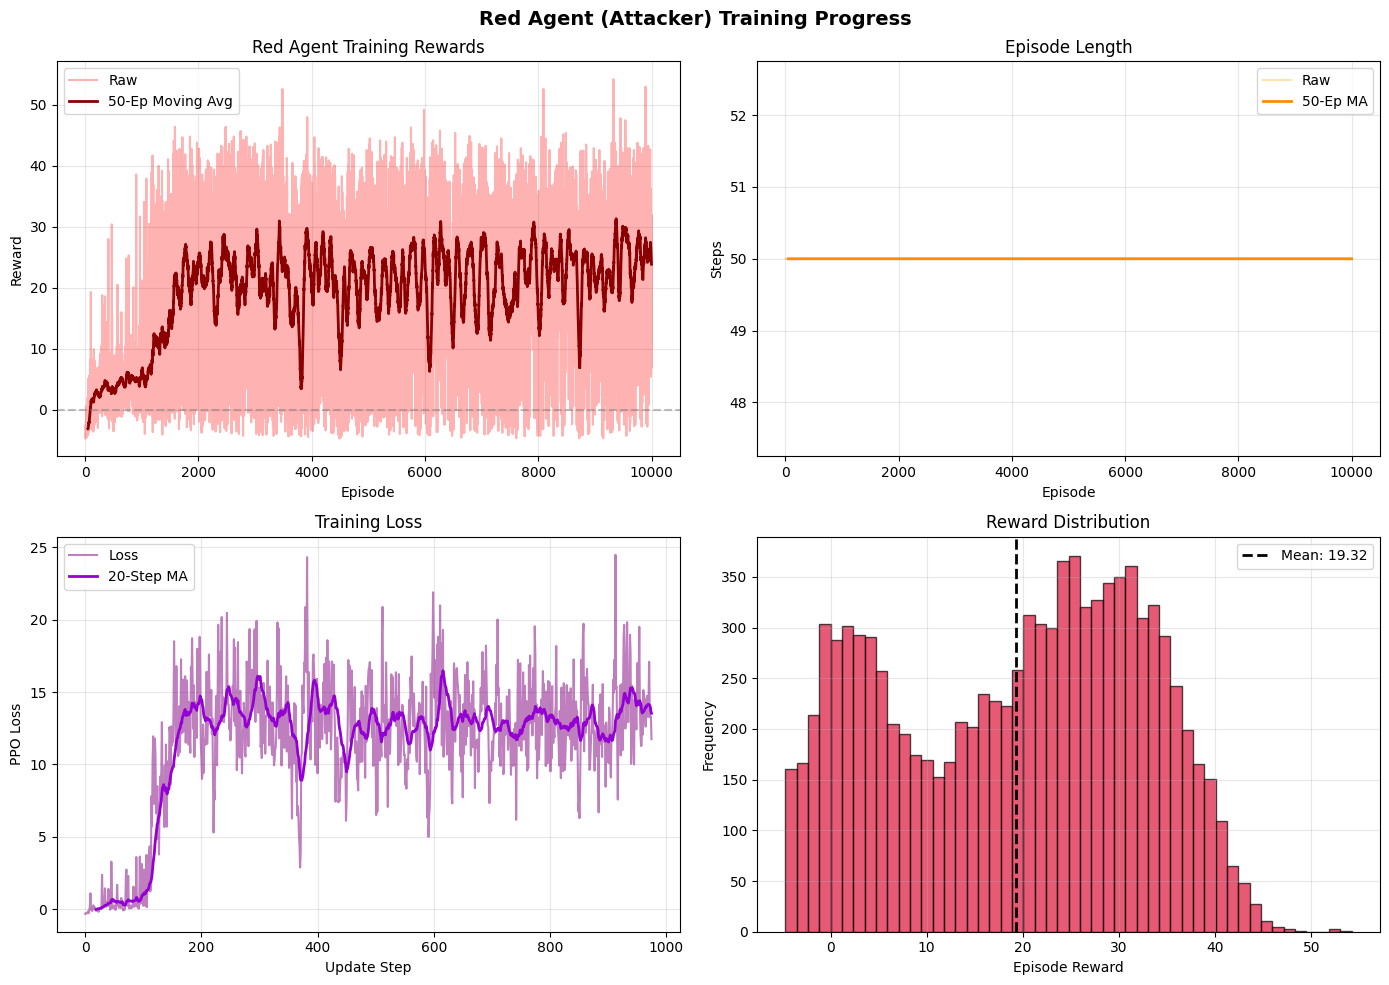


TRAINING STATISTICS
Total Episodes: 10000
Final Avg Reward (last 100): 24.68
Best Avg Reward: 29.81
Reward Std: 12.95
Max Single Episode Reward: 54.20
Min Single Episode Reward: -4.70


In [39]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Episode Rewards
ax1 = axes[0, 0]
ax1.plot(red_episode_rewards, alpha=0.3, color='red', label='Raw')
window = 50
if len(red_episode_rewards) >= window:
    moving_avg = np.convolve(red_episode_rewards, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(red_episode_rewards)), moving_avg, 
             color='darkred', linewidth=2, label=f'{window}-Ep Moving Avg')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.set_title('Red Agent Training Rewards')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Episode Length
ax2 = axes[0, 1]
ax2.plot(red_episode_lengths, alpha=0.3, color='orange', label='Raw')
if len(red_episode_lengths) >= window:
    length_ma = np.convolve(red_episode_lengths, np.ones(window)/window, mode='valid')
    ax2.plot(range(window-1, len(red_episode_lengths)), length_ma, 
             color='darkorange', linewidth=2, label=f'{window}-Ep MA')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Steps')
ax2.set_title('Episode Length')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Training Loss
ax3 = axes[1, 0]
if red_training_losses:
    ax3.plot(red_training_losses, alpha=0.5, color='purple', label='Loss')
    loss_window = min(20, len(red_training_losses))
    if len(red_training_losses) >= loss_window:
        loss_ma = np.convolve(red_training_losses, np.ones(loss_window)/loss_window, mode='valid')
        ax3.plot(range(loss_window-1, len(red_training_losses)), loss_ma, 
                 color='darkviolet', linewidth=2, label=f'{loss_window}-Step MA')
ax3.set_xlabel('Update Step')
ax3.set_ylabel('PPO Loss')
ax3.set_title('Training Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Reward Distribution
ax4 = axes[1, 1]
ax4.hist(red_episode_rewards, bins=50, color='crimson', alpha=0.7, edgecolor='black')
ax4.axvline(x=np.mean(red_episode_rewards), color='black', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(red_episode_rewards):.2f}')
ax4.set_xlabel('Episode Reward')
ax4.set_ylabel('Frequency')
ax4.set_title('Reward Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Red Agent (Attacker) Training Progress', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTRAINING STATISTICS")
print(f"Total Episodes: {len(red_episode_rewards)}")
print(f"Final Avg Reward (last 100): {np.mean(red_episode_rewards[-100:]):.2f}")
print(f"Best Avg Reward: {best_red_reward:.2f}")
print(f"Reward Std: {np.std(red_episode_rewards):.2f}")
print(f"Max Single Episode Reward: {np.max(red_episode_rewards):.2f}")
print(f"Min Single Episode Reward: {np.min(red_episode_rewards):.2f}")


In [40]:
try:
    red_actor.load_state_dict(torch.load('red_gnn_actor_best.pth', map_location=device))
except:
    pass

red_actor.eval()
NUM_EVAL_EPISODES = 100
eval_rewards, eval_lengths, eval_attack_patterns = [], [], []

with torch.no_grad():
    for ep in range(NUM_EVAL_EPISODES):
        obs, info = red_env.reset()
        action_mask = info.get('action_mask', None)
        ep_reward, ep_length, ep_actions = 0, 0, []
        
        done = False
        while not done:
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
            logits = red_actor(obs_t, A_static)
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, dtype=torch.bool, device=device)
                logits = logits.masked_fill(~mask_t, -1e9)
            
            action = torch.argmax(logits, dim=1).item()
            ep_actions.append(action)
            obs, reward, done, truncated, info = red_env.step(action)
            action_mask = info.get('action_mask', None)
            ep_reward += reward
            ep_length += 1
        
        eval_rewards.append(ep_reward)
        eval_lengths.append(ep_length)
        eval_attack_patterns.append(ep_actions)

print(f"Red Eval: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")

random_rewards = []
for _ in range(50):
    obs, info = red_env.reset()
    action_mask = info.get('action_mask', None)
    ep_reward = 0
    done = False
    
    while not done:
        if action_mask is not None:
            valid_actions = np.where(action_mask == 1)[0]
            action = np.random.choice(valid_actions)
        else:
            action = red_env.action_space.sample()
        obs, reward, done, truncated, info = red_env.step(action)
        action_mask = info.get('action_mask', None)
        ep_reward += reward
    
    random_rewards.append(ep_reward)

improvement = ((np.mean(eval_rewards) - np.mean(random_rewards)) / abs(np.mean(random_rewards))) * 100
print(f"Random baseline: {np.mean(random_rewards):.2f}, Improvement: {improvement:.1f}%")


EVALUATING TRAINED RED AGENT
Loaded best Red actor model
  Evaluated 20/100 episodes...
  Evaluated 40/100 episodes...
  Evaluated 60/100 episodes...
  Evaluated 80/100 episodes...
  Evaluated 100/100 episodes...

EVALUATION RESULTS
Average Reward: 45.40 ± 0.00
Median Reward: 45.40
Min Reward: 45.40
Max Reward: 45.40
Average Episode Length: 50.0

Comparing with Random Red Agent...

Random Red Agent Avg Reward: -3.94 ± 1.04
Trained Red Agent Avg Reward: 45.40 ± 0.00
Improvement: 1253.5%


ANALYZING RED AGENT ATTACK PATTERNS...


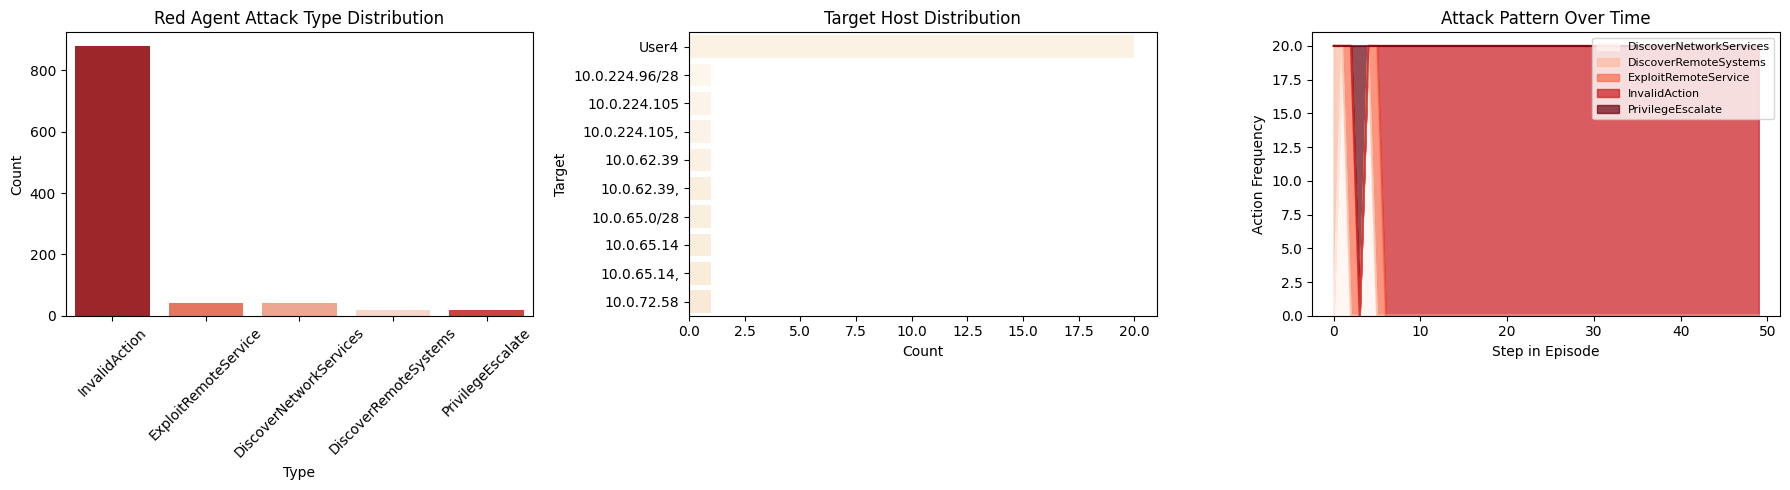


RED AGENT BEHAVIORAL INSIGHTS
1. Primary Attack Type: 'InvalidAction'
2. Most Targeted Host: 'User4'
3. Attack Diversity: 5 different attack types used
4. Early Phase (Step <15): Primarily 'InvalidAction'
5. Late Phase (Step >=30): Primarily 'InvalidAction'

Average Reward by Attack Type:
   InvalidAction: 1.00
   ExploitRemoteService: 0.60
   PrivilegeEscalate: 0.10
   DiscoverNetworkServices: 0.05
   DiscoverRemoteSystems: 0.00


In [41]:
import pandas as pd
import seaborn as sns

red_history = []
red_action_map = {}

red_actor.eval()
with torch.no_grad():
    for ep in range(20):
        obs, info = red_env.reset()
        action_mask = info.get('action_mask', None)
        done, step = False, 0
        
        while not done:
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
            logits = red_actor(obs_t, A_static)
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, dtype=torch.bool, device=device)
                logits = logits.masked_fill(~mask_t, -1e9)
            
            action_idx = torch.argmax(logits, dim=1).item()
            obs, reward, done, truncated, info = red_env.step(action_idx)
            action_mask = info.get('action_mask', None)
            
            action_str = f"Action {action_idx}"
            try:
                if hasattr(red_env, 'cyborg'):
                    last_action = red_env.cyborg.get_last_action('Red')
                    if last_action is not None:
                        action_str = str(last_action)
                        red_action_map[action_idx] = action_str
            except:
                pass
            
            if action_idx in red_action_map:
                action_str = red_action_map[action_idx]
            
            parts = str(action_str).split(' ')
            act_type = parts[0]
            target = parts[1] if len(parts) > 1 else "None"
            
            red_history.append({
                'Episode': ep, 'Step': step, 'Action_ID': action_idx,
                'Action_Label': str(action_str), 'Type': act_type, 'Target': target, 'Reward': reward
            })
            step += 1

df_red = pd.DataFrame(red_history)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

if not df_red.empty:
    sns.countplot(data=df_red, x='Type', ax=axes[0], hue='Type', 
                  palette='Reds', order=df_red['Type'].value_counts().index[:10], legend=False)
    axes[0].set_title("Attack Type Distribution")
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis='x', rotation=45)

    df_targets = df_red[df_red['Target'] != 'None']
    if not df_targets.empty:
        sns.countplot(data=df_targets, y='Target', ax=axes[1], hue='Target',
                      palette='OrRd', order=df_targets['Target'].value_counts().index[:10], legend=False)
        axes[1].set_title("Target Distribution")
        axes[1].set_xlabel("Count")

    action_counts = df_red.groupby(['Step', 'Type']).size().unstack(fill_value=0)
    if not action_counts.empty:
        action_counts.plot(kind='area', stacked=True, ax=axes[2], alpha=0.7, cmap='Reds')
        axes[2].set_title("Attack Pattern Over Time")
        axes[2].set_xlabel("Step")
        axes[2].set_ylabel("Frequency")
        axes[2].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

if not df_red.empty:
    top_attack = df_red['Type'].mode()[0]
    print(f"1. Primary Attack Type: '{top_attack}'")
    
    if not df_targets.empty:
        top_target = df_targets['Target'].mode()[0]
        print(f"2. Most Targeted Host: '{top_target}'")
    
    # Attack variety
    unique_attacks = df_red['Type'].nunique()
    print(f"3. Attack Diversity: {unique_attacks} different attack types used")
    
    # Phase analysis
    early_phase = df_red[df_red['Step'] < 15]['Type'].mode()
    late_phase = df_red[df_red['Step'] >= 30]['Type'].mode()
    
    if len(early_phase) > 0 and len(late_phase) > 0:
        print(f"4. Early Phase (Step <15): Primarily '{early_phase[0]}'")
        print(f"5. Late Phase (Step >=30): Primarily '{late_phase[0]}'")
    
    # Average reward by action type
    print("\nAverage Reward by Attack Type:")
    reward_by_type = df_red.groupby('Type')['Reward'].mean().sort_values(ascending=False)
    for act_type, avg_reward in reward_by_type.head(5).items():
        print(f"   {act_type}: {avg_reward:.2f}")



MULTI-AGENT INTRUSION DETECTION - FINAL SUMMARY


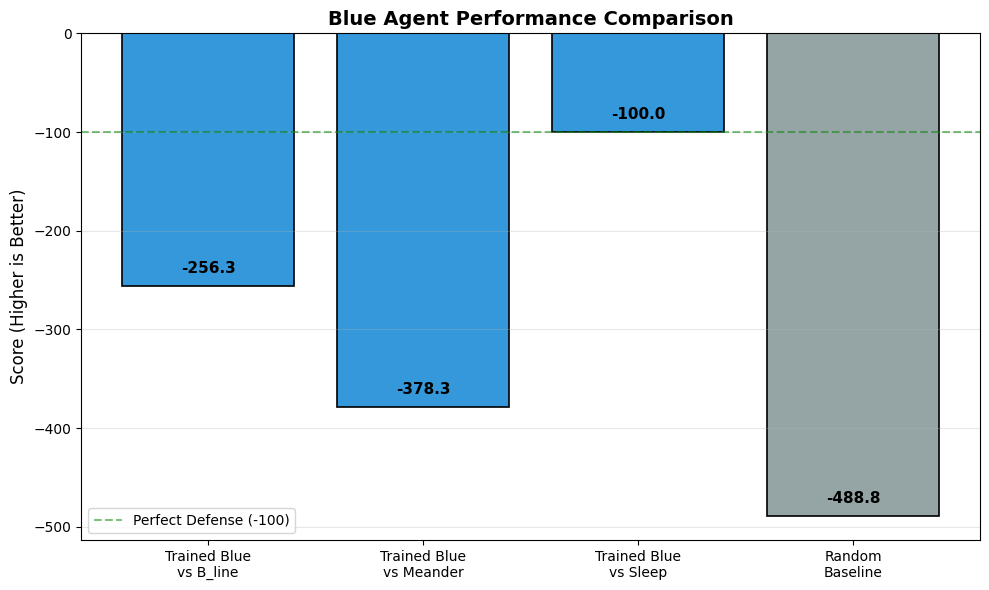

PROJECT COMPLETE - Multi-Agent Adversarial Training Implemented


In [42]:
fig, ax = plt.subplots(figsize=(10, 6))

agents = ['Trained Blue\nvs B_line', 'Trained Blue\nvs Meander', 
          'Trained Blue\nvs Sleep', 'Random\nBaseline']
blue_scores = [-256.30, -378.32, -100.00, -488.80]
colors = ['#3498db', '#3498db', '#3498db', '#95a5a6']

bars = ax.bar(agents, blue_scores, color=colors, edgecolor='black', linewidth=1.2)

for bar, score in zip(bars, blue_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{score:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=-100, color='green', linestyle='--', alpha=0.5, label='Perfect Defense')
ax.set_ylabel('Score')
ax.set_title('Blue Agent Performance')
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [43]:
for action_type, stats in action_reward_tracker.items():
    if stats['count'] > 0:
        avg = stats['total_reward'] / stats['count']
        print(f"{action_type}: {stats['count']} times, avg: {avg:.3f}")


Action-Reward Summary:
  PrivilegeEscalate: 7350 times, avg reward: 0.412
  ExploitRemoteService: 8408 times, avg reward: 0.470
  DiscoverNetworkServices: 1692 times, avg reward: 0.557
  DiscoverRemoteSystems: 19245 times, avg reward: 0.261
  Impact: 8674 times, avg reward: 0.444
  Sleep: 8848 times, avg reward: 0.437
  InvalidAction: 445783 times, avg reward: 0.387


In [44]:
print("ADVERSARIAL SELF-PLAY - ITERATION 1")
print("TRAINING BLUE AGENT (Against Trained Red)")

# Load trained Red agent for use as opponent
red_model_path = 'red_gnn_actor_final.pth'
if os.path.exists(red_model_path):
    red_actor_opponent = RedGNNActor(obs_dim=78, action_dim=56).to(device)
    red_actor_opponent.load_state_dict(torch.load(red_model_path, map_location=device))
    red_actor_opponent.eval()
    for param in red_actor_opponent.parameters():
        param.requires_grad = False
    print(f"Loaded trained Red actor from '{red_model_path}'")
    print(f"Red agent frozen (no gradient updates)")
else:
    print(f"'{red_model_path}' not found!")

# Re-initialize Blue networks with warm start
blue_actor_iter1 = RobustGNNActor(action_dim=54).to(device)
blue_critic_iter1 = RobustGNNCritic().to(device)

if os.path.exists('robust_gnn_actor.pth'):
    blue_actor_iter1.load_state_dict(torch.load('robust_gnn_actor.pth', map_location=device))
    print("Warm-started Blue actor from robust_gnn_actor.pth")
if os.path.exists('robust_gnn_critic.pth'):
    blue_critic_iter1.load_state_dict(torch.load('robust_gnn_critic.pth', map_location=device))
    print("Warm-started Blue critic from robust_gnn_critic.pth")

blue_optimizer_iter1 = optim.Adam(
    list(blue_actor_iter1.parameters()) + list(blue_critic_iter1.parameters()),
    lr=3e-4
)

# Config
ITER1_NUM_EPISODES = 5000
ITER1_MAX_STEPS = 50
ITER1_UPDATE_EVERY = 256
ITER1_PPO_EPOCHS = 4
ITER1_PPO_CLIP = 0.2
ITER1_GAMMA = 0.99
ITER1_GAE_LAMBDA = 0.95
ITER1_ENTROPY_COEF = 0.01
ITER1_MAX_GRAD_NORM = 0.5
ITER1_VALUE_COEF = 0.25

print(f"\nTraining Configuration:")
print(f"   Episodes: {ITER1_NUM_EPISODES}")
print(f"   Update every: {ITER1_UPDATE_EVERY} steps")

# Buffers
iter1_buffer_states = []
iter1_buffer_actions = []
iter1_buffer_logprobs = []
iter1_buffer_rewards = []
iter1_buffer_values = []
iter1_buffer_dones = []
iter1_buffer_masks = []

iter1_episode_rewards = []
best_iter1_reward = float('-inf')
iter1_total_steps = 0
iter1_start_time = time.time()

print("\nStarting Blue training iteration 1...")

for episode in range(ITER1_NUM_EPISODES):
    # Use trained Red as opponent (via MeanderAgent style - Red takes actions based on its policy)
    obs, info = env.reset()
    episode_reward = 0
    action_mask = info.get('action_mask', None)

    for step in range(ITER1_MAX_STEPS):
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = blue_actor_iter1(obs_t, A_static)
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, device=device)
                logits = logits.masked_fill(mask_t == 0, -1e9)
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            value = blue_critic_iter1(obs_t, A_static)

        action_idx = action.item()
        obs_next, reward, done, truncated, info = env.step(action_idx)
        done = done or truncated
        next_action_mask = info.get('action_mask', None)

        # Store in buffer
        iter1_buffer_states.append(obs_t)
        iter1_buffer_actions.append(action_idx)
        iter1_buffer_logprobs.append(log_prob.item())
        iter1_buffer_rewards.append(reward * 0.1)  # Scale reward
        iter1_buffer_values.append(value.item())
        iter1_buffer_dones.append(done)
        iter1_buffer_masks.append(action_mask if action_mask is not None else np.ones(54))

        episode_reward += reward * 0.1
        iter1_total_steps += 1

        # PPO Update
        if iter1_total_steps % ITER1_UPDATE_EVERY == 0 and len(iter1_buffer_states) > 0:
            with torch.no_grad():
                obs_next_t = torch.FloatTensor(obs_next).unsqueeze(0).to(device)
                next_value = blue_critic_iter1(obs_next_t, A_static).item()

            advantages, returns = compute_gae(
                iter1_buffer_rewards, iter1_buffer_values, iter1_buffer_dones,
                next_value, ITER1_GAMMA, ITER1_GAE_LAMBDA
            )

            states = torch.cat(iter1_buffer_states, dim=0).to(device)
            actions = torch.tensor(iter1_buffer_actions, dtype=torch.long).to(device)
            old_logprobs = torch.tensor(iter1_buffer_logprobs, dtype=torch.float32).to(device)
            advantages_t = torch.tensor(advantages, dtype=torch.float32).to(device)
            returns_t = torch.tensor(returns, dtype=torch.float32).to(device)
            masks = torch.tensor(np.array(iter1_buffer_masks), dtype=torch.bool).to(device)

            advantages_t = (advantages_t - advantages_t.mean()) / (advantages_t.std() + 1e-8)

            for _ in range(ITER1_PPO_EPOCHS):
                logits = blue_actor_iter1(states, A_static)
                logits = logits.masked_fill(~masks, -1e9)
                dist = torch.distributions.Categorical(logits=logits)
                new_logprobs = dist.log_prob(actions)
                entropy = dist.entropy().mean()
                new_values = blue_critic_iter1(states, A_static)

                ratio = torch.exp(new_logprobs - old_logprobs)
                surr1 = ratio * advantages_t
                surr2 = torch.clamp(ratio, 1 - ITER1_PPO_CLIP, 1 + ITER1_PPO_CLIP) * advantages_t
                actor_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(new_values, returns_t)

                loss = actor_loss + ITER1_VALUE_COEF * value_loss - ITER1_ENTROPY_COEF * entropy

                blue_optimizer_iter1.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(
                    list(blue_actor_iter1.parameters()) + list(blue_critic_iter1.parameters()),
                    ITER1_MAX_GRAD_NORM
                )
                blue_optimizer_iter1.step()

            # Clear buffers
            iter1_buffer_states.clear()
            iter1_buffer_actions.clear()
            iter1_buffer_logprobs.clear()
            iter1_buffer_rewards.clear()
            iter1_buffer_values.clear()
            iter1_buffer_dones.clear()
            iter1_buffer_masks.clear()

        obs = obs_next
        action_mask = next_action_mask
        if done:
            break

    iter1_episode_rewards.append(episode_reward)

    if episode >= 100:
        avg_reward = np.mean(iter1_episode_rewards[-100:])
        if avg_reward > best_iter1_reward:
            best_iter1_reward = avg_reward
            torch.save(blue_actor_iter1.state_dict(), 'blue_actor_iter1_best.pth')
            torch.save(blue_critic_iter1.state_dict(), 'blue_critic_iter1_best.pth')

    if episode % 500 == 0:
        avg_reward = np.mean(iter1_episode_rewards[-100:]) if len(iter1_episode_rewards) >= 100 else np.mean(iter1_episode_rewards)
        elapsed = time.time() - iter1_start_time
        print(f"Ep {episode:5d} | Avg Reward: {avg_reward:8.2f} | Steps: {iter1_total_steps:,} | Time: {elapsed:.1f}s")

torch.save(blue_actor_iter1.state_dict(), 'blue_actor_iter1_final.pth')
torch.save(blue_critic_iter1.state_dict(), 'blue_critic_iter1_final.pth')

print("\nADVERSARIAL ITERATION 1 COMPLETE!")
print(f"   Best avg reward: {best_iter1_reward:.2f}")
print(f"   Final avg reward: {np.mean(iter1_episode_rewards[-100:]):.2f}")
print("   Saved: blue_actor_iter1_final.pth, blue_critic_iter1_final.pth")


ADVERSARIAL SELF-PLAY - ITERATION 1
TRAINING BLUE AGENT (Against Trained Red)
Loaded trained Red actor from 'red_gnn_actor_final.pth'
Red agent frozen (no gradient updates)
Warm-started Blue actor from robust_gnn_actor.pth
Warm-started Blue critic from robust_gnn_critic.pth

Training Configuration:
   Episodes: 5000
   Update every: 256 steps

Starting Blue training iteration 1...
Ep     0 | Avg Reward:    -2.88 | Steps: 50 | Time: 0.3s


/tmp/ipython-input-2698653812.py:143: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(new_values, returns_t)


Ep   500 | Avg Reward:    -3.23 | Steps: 25,050 | Time: 158.8s
Ep  1000 | Avg Reward:    -3.03 | Steps: 50,050 | Time: 308.3s
Ep  1500 | Avg Reward:    -3.66 | Steps: 75,050 | Time: 457.8s
Ep  2000 | Avg Reward:    -2.85 | Steps: 100,050 | Time: 608.1s
Ep  2500 | Avg Reward:    -2.96 | Steps: 125,050 | Time: 762.0s
Ep  3000 | Avg Reward:    -2.13 | Steps: 150,050 | Time: 913.9s
Ep  3500 | Avg Reward:    -2.93 | Steps: 175,050 | Time: 1069.6s
Ep  4000 | Avg Reward:    -2.47 | Steps: 200,050 | Time: 1228.0s
Ep  4500 | Avg Reward:    -2.23 | Steps: 225,050 | Time: 1393.3s

ADVERSARIAL ITERATION 1 COMPLETE!
   Best avg reward: -1.80
   Final avg reward: -2.29
   Saved: blue_actor_iter1_final.pth, blue_critic_iter1_final.pth


In [45]:
print("ADVERSARIAL SELF-PLAY - ITERATION 2")
print("TRAINING RED AGENT (Against Iter1 Blue)")

# Load Iter1 Blue agent
blue_iter1_path = 'blue_actor_iter1_final.pth'
if os.path.exists(blue_iter1_path):
    blue_actor_iter1_loaded = RobustGNNActor(action_dim=54).to(device)
    blue_actor_iter1_loaded.load_state_dict(torch.load(blue_iter1_path, map_location=device))
    blue_actor_iter1_loaded.eval()
    for param in blue_actor_iter1_loaded.parameters():
        param.requires_grad = False
    print(f"Loaded Iter1 Blue actor from '{blue_iter1_path}'")
    print(f"Blue agent frozen")
else:
    print(f"'{blue_iter1_path}' not found!")
    blue_actor_iter1_loaded = blue_actor_iter1
    blue_actor_iter1_loaded.eval()

# Initialize Red with warm start
red_actor_iter2 = RedGNNActor(obs_dim=78, action_dim=56).to(device)
red_critic_iter2 = RedGNNCritic(obs_dim=78).to(device)

if os.path.exists('red_gnn_actor_final.pth'):
    red_actor_iter2.load_state_dict(torch.load('red_gnn_actor_final.pth', map_location=device))
    print("Warm-started Red actor from red_gnn_actor_final.pth")
if os.path.exists('red_gnn_critic_final.pth'):
    red_critic_iter2.load_state_dict(torch.load('red_gnn_critic_final.pth', map_location=device))
    print("Warm-started Red critic from red_gnn_critic_final.pth")

red_optimizer_iter2 = optim.Adam(
    list(red_actor_iter2.parameters()) + list(red_critic_iter2.parameters()),
    lr=3e-4
)

# Create Red environment with Iter1 Blue
red_env_iter2 = MiniCageRed(
    trained_blue_actor=blue_actor_iter1_loaded,
    adjacency_matrix=A_static,
    max_steps=50,
    device=device
)

ITER2_NUM_EPISODES = 5000
ITER2_MAX_STEPS = 50
ITER2_UPDATE_EVERY = 512
ITER2_PPO_EPOCHS = 4
ITER2_PPO_CLIP = 0.2
ITER2_GAMMA = 0.99
ITER2_GAE_LAMBDA = 0.95
ITER2_ENTROPY_COEF = 0.1
ITER2_MAX_GRAD_NORM = 0.5
ITER2_VALUE_COEF = 0.5

print(f"\nTraining Configuration:")
print(f"   Episodes: {ITER2_NUM_EPISODES}")

iter2_episode_rewards = []
best_iter2_reward = float('-inf')
red_buffer_iter2 = RedRolloutBuffer()

print("\nStarting Red training iteration 2...")
iter2_total_steps = 0
iter2_start_time = time.time()

for episode in range(ITER2_NUM_EPISODES):
    obs, info = red_env_iter2.reset()
    action_mask = info.get('action_mask', None)
    episode_reward = 0

    for step in range(ITER2_MAX_STEPS):
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = red_actor_iter2(obs_t, A_static)
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, dtype=torch.bool, device=device)
                logits = logits.masked_fill(~mask_t, -1e9)
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            value = red_critic_iter2(obs_t, A_static)

        action_idx = action.item()
        next_obs, reward, done, truncated, info = red_env_iter2.step(action_idx)
        next_action_mask = info.get('action_mask', None)

        red_buffer_iter2.add(obs_t, action_idx, log_prob.item(), reward, value.item(), done,
                             action_mask if action_mask is not None else np.ones(56))

        episode_reward += reward
        iter2_total_steps += 1

        if len(red_buffer_iter2) >= ITER2_UPDATE_EVERY:
            with torch.no_grad():
                next_obs_t = torch.FloatTensor(next_obs).unsqueeze(0).to(device)
                next_value = red_critic_iter2(next_obs_t, A_static).item()

            advantages, returns = compute_gae_returns(
                red_buffer_iter2.rewards, red_buffer_iter2.values, red_buffer_iter2.dones,
                next_value, ITER2_GAMMA, ITER2_GAE_LAMBDA
            )

            states = torch.cat(red_buffer_iter2.states, dim=0).to(device)
            actions_t = torch.tensor(red_buffer_iter2.actions, dtype=torch.long, device=device)
            old_logprobs = torch.tensor(red_buffer_iter2.logprobs, dtype=torch.float32, device=device)
            advantages_t = torch.tensor(advantages, dtype=torch.float32, device=device)
            returns_t = torch.tensor(returns, dtype=torch.float32, device=device)
            masks = torch.tensor(np.array(red_buffer_iter2.masks), dtype=torch.bool, device=device)

            advantages_t = (advantages_t - advantages_t.mean()) / (advantages_t.std() + 1e-8)

            for _ in range(ITER2_PPO_EPOCHS):
                logits = red_actor_iter2(states, A_static)
                logits = logits.masked_fill(~masks, -1e9)
                dist = torch.distributions.Categorical(logits=logits)
                new_logprobs = dist.log_prob(actions_t)
                entropy = dist.entropy().mean()
                values = red_critic_iter2(states, A_static)

                ratio = torch.exp(new_logprobs - old_logprobs)
                surr1 = ratio * advantages_t
                surr2 = torch.clamp(ratio, 1 - ITER2_PPO_CLIP, 1 + ITER2_PPO_CLIP) * advantages_t
                actor_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(values, returns_t)

                loss = actor_loss + ITER2_VALUE_COEF * value_loss - ITER2_ENTROPY_COEF * entropy

                red_optimizer_iter2.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(
                    list(red_actor_iter2.parameters()) + list(red_critic_iter2.parameters()),
                    ITER2_MAX_GRAD_NORM
                )
                red_optimizer_iter2.step()

            red_buffer_iter2.clear()

        obs = next_obs
        action_mask = next_action_mask
        if done:
            break

    iter2_episode_rewards.append(episode_reward)

    if episode >= 100:
        avg_reward = np.mean(iter2_episode_rewards[-100:])
        if avg_reward > best_iter2_reward:
            best_iter2_reward = avg_reward
            torch.save(red_actor_iter2.state_dict(), 'red_actor_iter2_best.pth')

    if episode % 500 == 0:
        avg_reward = np.mean(iter2_episode_rewards[-100:]) if len(iter2_episode_rewards) >= 100 else np.mean(iter2_episode_rewards)
        elapsed = time.time() - iter2_start_time
        print(f"Ep {episode:5d} | Avg Reward: {avg_reward:8.2f} | Steps: {iter2_total_steps:,} | Time: {elapsed:.1f}s")

torch.save(red_actor_iter2.state_dict(), 'red_actor_iter2_final.pth')
torch.save(red_critic_iter2.state_dict(), 'red_critic_iter2_final.pth')

print("\nADVERSARIAL ITERATION 2 COMPLETE!")
print(f"   Best avg reward: {best_iter2_reward:.2f}")
print(f"   Final avg reward: {np.mean(iter2_episode_rewards[-100:]):.2f}")
print("   Saved: red_actor_iter2_final.pth, red_critic_iter2_final.pth")

ADVERSARIAL SELF-PLAY - ITERATION 2
TRAINING RED AGENT (Against Iter1 Blue)
Loaded Iter1 Blue actor from 'blue_actor_iter1_final.pth'
Blue agent frozen
Warm-started Red actor from red_gnn_actor_final.pth
Warm-started Red critic from red_gnn_critic_final.pth

Training Configuration:
   Episodes: 5000

Starting Red training iteration 2...
Ep     0 | Avg Reward:    17.70 | Steps: 50 | Time: 0.4s
Ep   500 | Avg Reward:    26.19 | Steps: 25,050 | Time: 235.0s
Ep  1000 | Avg Reward:    25.84 | Steps: 50,050 | Time: 461.4s
Ep  1500 | Avg Reward:    29.46 | Steps: 75,050 | Time: 688.4s
Ep  2000 | Avg Reward:    25.90 | Steps: 100,050 | Time: 916.6s
Ep  2500 | Avg Reward:    22.75 | Steps: 125,050 | Time: 1144.8s
Ep  3000 | Avg Reward:    22.63 | Steps: 150,050 | Time: 1375.5s
Ep  3500 | Avg Reward:    28.88 | Steps: 175,050 | Time: 1605.4s
Ep  4000 | Avg Reward:    22.02 | Steps: 200,050 | Time: 1842.1s
Ep  4500 | Avg Reward:    25.50 | Steps: 225,050 | Time: 2074.0s

ADVERSARIAL ITERATION 2 C

In [46]:
print("ADVERSARIAL SELF-PLAY - ITERATION 3 (FINAL)")
print("TRAINING BLUE AGENT (Against Iter2 Red)")

# Load Iter2 Red agent
red_iter2_path = 'red_actor_iter2_final.pth'
if os.path.exists(red_iter2_path):
    red_actor_iter2_loaded = RedGNNActor(obs_dim=78, action_dim=56).to(device)
    red_actor_iter2_loaded.load_state_dict(torch.load(red_iter2_path, map_location=device))
    red_actor_iter2_loaded.eval()
    for param in red_actor_iter2_loaded.parameters():
        param.requires_grad = False
    print(f"Loaded Iter2 Red actor from '{red_iter2_path}'")
    print(f"Red agent frozen")
else:
    print(f"'{red_iter2_path}' not found!")

# Initialize Blue with warm start from Iter1
blue_actor_iter3 = RobustGNNActor(action_dim=54).to(device)
blue_critic_iter3 = RobustGNNCritic().to(device)

if os.path.exists('blue_actor_iter1_final.pth'):
    blue_actor_iter3.load_state_dict(torch.load('blue_actor_iter1_final.pth', map_location=device))
    print("Warm-started Blue actor from iter1")
if os.path.exists('blue_critic_iter1_final.pth'):
    blue_critic_iter3.load_state_dict(torch.load('blue_critic_iter1_final.pth', map_location=device))
    print("Warm-started Blue critic from iter1")

blue_optimizer_iter3 = optim.Adam(
    list(blue_actor_iter3.parameters()) + list(blue_critic_iter3.parameters()),
    lr=3e-4
)

ITER3_NUM_EPISODES = 5000
ITER3_MAX_STEPS = 50
ITER3_UPDATE_EVERY = 256
ITER3_PPO_EPOCHS = 4
ITER3_PPO_CLIP = 0.2
ITER3_GAMMA = 0.99
ITER3_GAE_LAMBDA = 0.95
ITER3_ENTROPY_COEF = 0.01
ITER3_MAX_GRAD_NORM = 0.5
ITER3_VALUE_COEF = 0.25

print(f"\nTraining Configuration:")
print(f"   Episodes: {ITER3_NUM_EPISODES}")

# Buffers
iter3_buffer_states = []
iter3_buffer_actions = []
iter3_buffer_logprobs = []
iter3_buffer_rewards = []
iter3_buffer_values = []
iter3_buffer_dones = []
iter3_buffer_masks = []

iter3_episode_rewards = []
best_iter3_reward = float('-inf')
iter3_total_steps = 0
iter3_start_time = time.time()

print("\nStarting Blue training iteration 3 (final)...")

for episode in range(ITER3_NUM_EPISODES):
    obs, info = env.reset()
    episode_reward = 0
    action_mask = info.get('action_mask', None)

    for step in range(ITER3_MAX_STEPS):
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = blue_actor_iter3(obs_t, A_static)
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, device=device)
                logits = logits.masked_fill(mask_t == 0, -1e9)
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            value = blue_critic_iter3(obs_t, A_static)

        action_idx = action.item()
        obs_next, reward, done, truncated, info = env.step(action_idx)
        done = done or truncated
        next_action_mask = info.get('action_mask', None)

        iter3_buffer_states.append(obs_t)
        iter3_buffer_actions.append(action_idx)
        iter3_buffer_logprobs.append(log_prob.item())
        iter3_buffer_rewards.append(reward * 0.1)
        iter3_buffer_values.append(value.item())
        iter3_buffer_dones.append(done)
        iter3_buffer_masks.append(action_mask if action_mask is not None else np.ones(54))

        episode_reward += reward * 0.1
        iter3_total_steps += 1

        if iter3_total_steps % ITER3_UPDATE_EVERY == 0 and len(iter3_buffer_states) > 0:
            with torch.no_grad():
                obs_next_t = torch.FloatTensor(obs_next).unsqueeze(0).to(device)
                next_value = blue_critic_iter3(obs_next_t, A_static).item()

            advantages, returns = compute_gae(
                iter3_buffer_rewards, iter3_buffer_values, iter3_buffer_dones,
                next_value, ITER3_GAMMA, ITER3_GAE_LAMBDA
            )

            states = torch.cat(iter3_buffer_states, dim=0).to(device)
            actions = torch.tensor(iter3_buffer_actions, dtype=torch.long).to(device)
            old_logprobs = torch.tensor(iter3_buffer_logprobs, dtype=torch.float32).to(device)
            advantages_t = torch.tensor(advantages, dtype=torch.float32).to(device)
            returns_t = torch.tensor(returns, dtype=torch.float32).to(device)
            masks = torch.tensor(np.array(iter3_buffer_masks), dtype=torch.bool).to(device)

            advantages_t = (advantages_t - advantages_t.mean()) / (advantages_t.std() + 1e-8)

            for _ in range(ITER3_PPO_EPOCHS):
                logits = blue_actor_iter3(states, A_static)
                logits = logits.masked_fill(~masks, -1e9)
                dist = torch.distributions.Categorical(logits=logits)
                new_logprobs = dist.log_prob(actions)
                entropy = dist.entropy().mean()
                new_values = blue_critic_iter3(states, A_static)

                ratio = torch.exp(new_logprobs - old_logprobs)
                surr1 = ratio * advantages_t
                surr2 = torch.clamp(ratio, 1 - ITER3_PPO_CLIP, 1 + ITER3_PPO_CLIP) * advantages_t
                actor_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(new_values, returns_t)

                loss = actor_loss + ITER3_VALUE_COEF * value_loss - ITER3_ENTROPY_COEF * entropy

                blue_optimizer_iter3.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(
                    list(blue_actor_iter3.parameters()) + list(blue_critic_iter3.parameters()),
                    ITER3_MAX_GRAD_NORM
                )
                blue_optimizer_iter3.step()

            iter3_buffer_states.clear()
            iter3_buffer_actions.clear()
            iter3_buffer_logprobs.clear()
            iter3_buffer_rewards.clear()
            iter3_buffer_values.clear()
            iter3_buffer_dones.clear()
            iter3_buffer_masks.clear()

        obs = obs_next
        action_mask = next_action_mask
        if done:
            break

    iter3_episode_rewards.append(episode_reward)

    if episode >= 100:
        avg_reward = np.mean(iter3_episode_rewards[-100:])
        if avg_reward > best_iter3_reward:
            best_iter3_reward = avg_reward
            torch.save(blue_actor_iter3.state_dict(), 'blue_actor_iter3_best.pth')
            torch.save(blue_critic_iter3.state_dict(), 'blue_critic_iter3_best.pth')

    if episode % 500 == 0:
        avg_reward = np.mean(iter3_episode_rewards[-100:]) if len(iter3_episode_rewards) >= 100 else np.mean(iter3_episode_rewards)
        elapsed = time.time() - iter3_start_time
        print(f"Ep {episode:5d} | Avg Reward: {avg_reward:8.2f} | Steps: {iter3_total_steps:,} | Time: {elapsed:.1f}s")

torch.save(blue_actor_iter3.state_dict(), 'blue_actor_iter3_final.pth')
torch.save(blue_critic_iter3.state_dict(), 'blue_critic_iter3_final.pth')


print("\nADVERSARIAL SELF-PLAY ITERATION 3 (FINAL) COMPLETE!")
print(f"   Best avg reward: {best_iter3_reward:.2f}")
print(f"   Final avg reward: {np.mean(iter3_episode_rewards[-100:]):.2f}")



print("\nADVERSARIAL SELF-PLAY TRAINING COMPLETE!")

print("\nFinal models saved:")
print("  Blue: blue_actor_iter3_final.pth (trained against strongest Red)")
print("  Red: red_actor_iter2_final.pth (trained against iter1 Blue)")



ADVERSARIAL SELF-PLAY - ITERATION 3 (FINAL)
TRAINING BLUE AGENT (Against Iter2 Red)
Loaded Iter2 Red actor from 'red_actor_iter2_final.pth'
Red agent frozen
Warm-started Blue actor from iter1
Warm-started Blue critic from iter1

Training Configuration:
   Episodes: 5000

Starting Blue training iteration 3 (final)...
Ep     0 | Avg Reward:    -0.58 | Steps: 50 | Time: 0.3s


/tmp/ipython-input-3031662036.py:135: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(new_values, returns_t)


Ep   500 | Avg Reward:    -2.47 | Steps: 25,050 | Time: 153.8s
Ep  1000 | Avg Reward:    -6.78 | Steps: 50,050 | Time: 306.0s
Ep  1500 | Avg Reward:    -2.09 | Steps: 75,050 | Time: 458.3s
Ep  2000 | Avg Reward:    -2.40 | Steps: 100,050 | Time: 609.9s
Ep  2500 | Avg Reward:    -2.92 | Steps: 125,050 | Time: 762.2s
Ep  3000 | Avg Reward:    -2.77 | Steps: 150,050 | Time: 913.9s
Ep  3500 | Avg Reward:    -2.03 | Steps: 175,050 | Time: 1065.2s
Ep  4000 | Avg Reward:    -2.64 | Steps: 200,050 | Time: 1219.0s
Ep  4500 | Avg Reward:    -2.10 | Steps: 225,050 | Time: 1370.4s

ADVERSARIAL SELF-PLAY ITERATION 3 (FINAL) COMPLETE!
   Best avg reward: -1.73
   Final avg reward: -2.11

ADVERSARIAL SELF-PLAY TRAINING COMPLETE!

Final models saved:
  Blue: blue_actor_iter3_final.pth (trained against strongest Red)
  Red: red_actor_iter2_final.pth (trained against iter1 Blue)


ADVERSARIAL SELF-PLAY EVALUATION

Loading trained models...
   Blue Baseline: robust_gnn_actor.pth
   Blue Iter1: blue_actor_iter1_final.pth
   Blue Iter3: blue_actor_iter3_final.pth
   Red Baseline: red_gnn_actor_final.pth
   Red Iter2: red_actor_iter2_final.pth

BLUE AGENT GREEDY EVALUATION (100 episodes each)

Evaluating Blue Baseline...
  Episode 0: -35.80
  Episode 20: -8.80
  Episode 40: -16.80
  Episode 60: -29.80
  Episode 80: -29.80
 Blue Baseline: -19.71 ± 13.94 (min: -76.80, max: -4.80)

Evaluating Blue Iter1...
  Episode 0: -26.80
  Episode 20: -22.80
  Episode 40: -16.80
  Episode 60: -10.80
  Episode 80: -29.80
 Blue Iter1: -20.60 ± 12.38 (min: -44.80, max: -4.80)

Evaluating Blue Iter3...
  Episode 0: -4.80
  Episode 20: -49.80
  Episode 40: -46.80
  Episode 60: -49.80
  Episode 80: -4.80
 Blue Iter3: -26.08 ± 20.91 (min: -54.80, max: -4.80)

RED AGENT GREEDY EVALUATION (100 episodes each)

Evaluating Red Baseline vs Blue Baseline...
  Episode 0: 49.80
  Episode 20: 49.8

/tmp/ipython-input-1415644867.py:205: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(blue_data, labels=blue_labels, patch_artist=True)
/tmp/ipython-input-1415644867.py:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax3.boxplot(red_data, labels=red_labels, patch_artist=True)


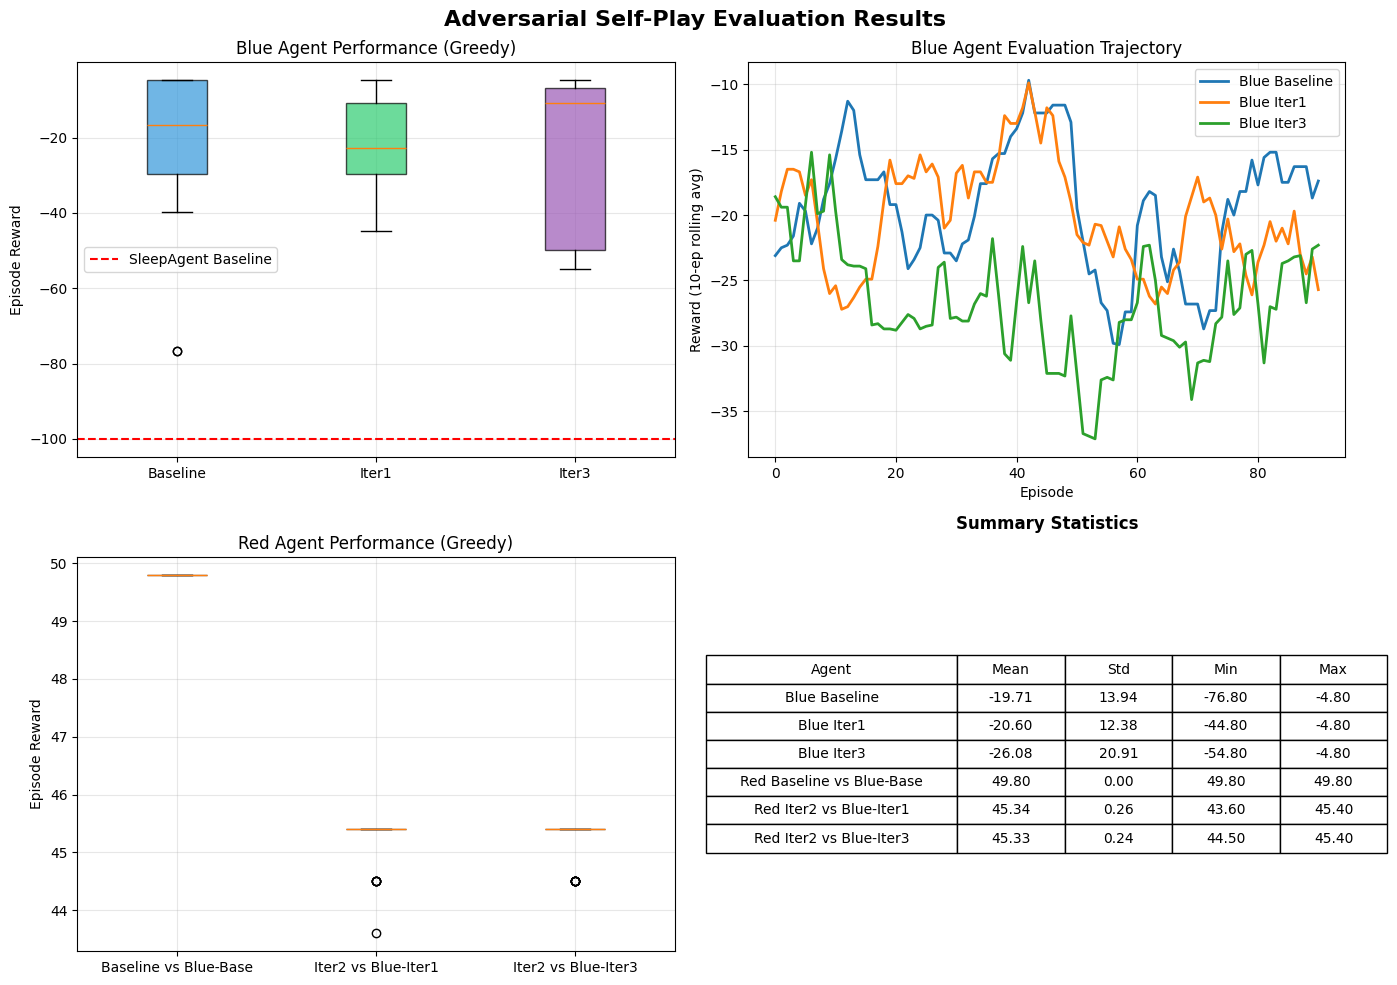


Saved: adversarial_selfplay_evaluation.png

SAMPLE GREEDY EPISODE PLAYBACK

Blue Baseline - Detailed Episode
  Step  0: Action 13 → Reward +0.00 (Total: +0.00)
  Step  1: Action 13 → Reward +0.00 (Total: +0.00)
  Step  2: Action 29 → Reward -0.10 (Total: -0.10)
  Step  3: Action 29 → Reward -0.10 (Total: -0.20)
  Step  4: Action 13 → Reward -0.10 (Total: -0.30)
  Step  5: Action 13 → Reward -0.10 (Total: -0.40)
  Step  6: Action 13 → Reward -0.10 (Total: -0.50)
  Step  7: Action 29 → Reward -0.10 (Total: -0.60)
  Step  8: Action 13 → Reward -0.10 (Total: -0.70)
  Step  9: Action 13 → Reward -0.10 (Total: -0.80)
  Step 10: Action 13 → Reward -0.10 (Total: -0.90)
  Step 20: Action 13 → Reward -0.10 (Total: -1.90)
  Step 30: Action 13 → Reward -0.10 (Total: -2.90)
  Step 40: Action 13 → Reward -0.10 (Total: -3.90)
  [Episode ended at step 49]

Final Reward: -4.80
Action Distribution:
     Action 13: 38 times
     Action 29: 12 times

Blue Iter1 - Detailed Episode
  Step  0: Action 35 → R

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


print("\nADVERSARIAL SELF-PLAY EVALUATION")


print("\nLoading trained models...")

# Blue agents
blue_models = {}
blue_model_files = [
    ('Baseline', 'robust_gnn_actor.pth'),
    ('Iter1', 'blue_actor_iter1_final.pth'),
    ('Iter3', 'blue_actor_iter3_final.pth'),
]

for name, path in blue_model_files:
    if os.path.exists(path):
        model = RobustGNNActor(action_dim=54).to(device)
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        blue_models[name] = model
        print(f"   Blue {name}: {path}")
    else:
        print(f"   Blue {name}: {path} not found")

# Red agents
red_models = {}
red_model_files = [
    ('Baseline', 'red_gnn_actor_final.pth'),
    ('Iter2', 'red_actor_iter2_final.pth'),
]

for name, path in red_model_files:
    if os.path.exists(path):
        model = RedGNNActor(obs_dim=78, action_dim=56).to(device)
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        red_models[name] = model
        print(f"   Red {name}: {path}")
    else:
        print(f"   Red {name}: {path} not found")

def evaluate_blue_greedy(blue_actor, num_episodes=100, max_steps=50, verbose=False):
    """Evaluate Blue agent with greedy action selection (no exploration)"""
    rewards = []
    
    for ep in range(num_episodes):
        obs, info = env.reset()
        action_mask = info.get('action_mask', None)
        episode_reward = 0
        
        for step in range(max_steps):
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
            
            with torch.no_grad():
                logits = blue_actor(obs_t, A_static)
                if action_mask is not None:
                    mask_t = torch.tensor(action_mask, device=device)
                    logits = logits.masked_fill(mask_t == 0, -1e9)
                action = logits.argmax(dim=-1).item()  # Greedy!
            
            obs, reward, done, truncated, info = env.step(action)
            action_mask = info.get('action_mask', None)
            episode_reward += reward
            
            if done or truncated:
                break
        
        rewards.append(episode_reward)
        
        if verbose and ep % 20 == 0:
            print(f"  Episode {ep}: {episode_reward:.2f}")
    
    return rewards

def evaluate_red_greedy(red_actor, blue_opponent, num_episodes=100, max_steps=50, verbose=False):
    """Evaluate Red agent with greedy action selection against a Blue opponent"""
    # Create environment with Blue opponent
    red_env = MiniCageRed(
        trained_blue_actor=blue_opponent,
        adjacency_matrix=A_static,
        max_steps=max_steps,
        device=device
    )
    
    rewards = []
    
    for ep in range(num_episodes):
        obs, info = red_env.reset()
        action_mask = info.get('action_mask', None)
        episode_reward = 0
        
        for step in range(max_steps):
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
            
            with torch.no_grad():
                logits = red_actor(obs_t, A_static)
                if action_mask is not None:
                    mask_t = torch.tensor(action_mask, dtype=torch.bool, device=device)
                    logits = logits.masked_fill(~mask_t, -1e9)
                action = logits.argmax(dim=-1).item()  # Greedy!
            
            obs, reward, done, truncated, info = red_env.step(action)
            action_mask = info.get('action_mask', None)
            episode_reward += reward
            
            if done or truncated:
                break
        
        rewards.append(episode_reward)
        
        if verbose and ep % 20 == 0:
            print(f"  Episode {ep}: {episode_reward:.2f}")
    
    return rewards

print("\nBLUE AGENT GREEDY EVALUATION (100 episodes each)")

blue_results = {}
for name, model in blue_models.items():
    print(f"\nEvaluating Blue {name}...")
    rewards = evaluate_blue_greedy(model, num_episodes=100, verbose=True)
    blue_results[name] = rewards
    avg = np.mean(rewards)
    std = np.std(rewards)
    print(f" Blue {name}: {avg:.2f} ± {std:.2f} (min: {min(rewards):.2f}, max: {max(rewards):.2f})")



print("\nRED AGENT GREEDY EVALUATION (100 episodes each)")

red_results = {}

# Evaluate each Red against the Blue it was trained against
if 'Baseline' in red_models and 'Baseline' in blue_models:
    print("\nEvaluating Red Baseline vs Blue Baseline...")
    rewards = evaluate_red_greedy(red_models['Baseline'], blue_models['Baseline'], num_episodes=100, verbose=True)
    red_results['Baseline vs Blue-Base'] = rewards
    avg = np.mean(rewards)
    std = np.std(rewards)
    print(f" Red Baseline: {avg:.2f} ± {std:.2f}")

if 'Iter2' in red_models and 'Iter1' in blue_models:
    print("\nEvaluating Red Iter2 vs Blue Iter1...")
    rewards = evaluate_red_greedy(red_models['Iter2'], blue_models['Iter1'], num_episodes=100, verbose=True)
    red_results['Iter2 vs Blue-Iter1'] = rewards
    avg = np.mean(rewards)
    std = np.std(rewards)
    print(f" Red Iter2: {avg:.2f} ± {std:.2f}")

# Cross-evaluation: Latest Red vs Latest Blue
if 'Iter2' in red_models and 'Iter3' in blue_models:
    print("\nEvaluating Red Iter2 vs Blue Iter3 (cross-eval)...")
    rewards = evaluate_red_greedy(red_models['Iter2'], blue_models['Iter3'], num_episodes=100, verbose=True)
    red_results['Iter2 vs Blue-Iter3'] = rewards
    avg = np.mean(rewards)
    std = np.std(rewards)
    print(f" Red Iter2 vs Blue Iter3: {avg:.2f} ± {std:.2f}")

print("\nGENERATING VISUALIZATIONS")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Adversarial Self-Play Evaluation Results', fontsize=16, fontweight='bold')

# Plot 1: Blue Agent Reward Distribution
ax1 = axes[0, 0]
blue_data = [blue_results[name] for name in blue_results.keys()]
blue_labels = list(blue_results.keys())
bp1 = ax1.boxplot(blue_data, labels=blue_labels, patch_artist=True)
colors_blue = ['#3498db', '#2ecc71', '#9b59b6']
for patch, color in zip(bp1['boxes'], colors_blue[:len(bp1['boxes'])]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.axhline(y=-100, color='red', linestyle='--', label='SleepAgent Baseline')
ax1.set_ylabel('Episode Reward')
ax1.set_title('Blue Agent Performance (Greedy)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Blue Agent Learning Curve (if training data available)
ax2 = axes[0, 1]
for name, rewards in blue_results.items():
    # Rolling average
    window = 10
    rolling_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax2.plot(rolling_avg, label=f'Blue {name}', linewidth=2)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Reward (10-ep rolling avg)')
ax2.set_title('Blue Agent Evaluation Trajectory')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Red Agent Reward Distribution
ax3 = axes[1, 0]
if red_results:
    red_data = [red_results[name] for name in red_results.keys()]
    red_labels = list(red_results.keys())
    bp3 = ax3.boxplot(red_data, labels=red_labels, patch_artist=True)
    colors_red = ['#e74c3c', '#c0392b', '#a93226']
    for patch, color in zip(bp3['boxes'], colors_red[:len(bp3['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax3.set_ylabel('Episode Reward')
    ax3.set_title('Red Agent Performance (Greedy)')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No Red results available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Red Agent Performance')

# Plot 4: Summary Statistics Table
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary table
summary_data = []
for name, rewards in blue_results.items():
    summary_data.append([f'Blue {name}', f'{np.mean(rewards):.2f}', f'{np.std(rewards):.2f}', 
                         f'{min(rewards):.2f}', f'{max(rewards):.2f}'])
for name, rewards in red_results.items():
    summary_data.append([f'Red {name}', f'{np.mean(rewards):.2f}', f'{np.std(rewards):.2f}',
                         f'{min(rewards):.2f}', f'{max(rewards):.2f}'])

table = ax4.table(
    cellText=summary_data,
    colLabels=['Agent', 'Mean', 'Std', 'Min', 'Max'],
    loc='center',
    cellLoc='center',
    colWidths=[0.35, 0.15, 0.15, 0.15, 0.15]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax4.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('adversarial_selfplay_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: adversarial_selfplay_evaluation.png")

print("\nSAMPLE GREEDY EPISODE PLAYBACK")

def play_detailed_episode(blue_actor, agent_name, max_steps=50):
    """Play one episode with detailed action logging"""
    obs, info = env.reset()
    action_mask = info.get('action_mask', None)
    
    print(f"\n{'='*60}")
    print(f"{agent_name} - Detailed Episode")
    print(f"{'='*60}")
    
    total_reward = 0
    action_counts = defaultdict(int)
    
    for step in range(max_steps):
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = blue_actor(obs_t, A_static)
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, device=device)
                logits = logits.masked_fill(mask_t == 0, -1e9)
            action = logits.argmax(dim=-1).item()
        
        obs, reward, done, truncated, info = env.step(action)
        action_mask = info.get('action_mask', None)
        total_reward += reward
        action_counts[action] += 1
        
        if step < 10 or step % 10 == 0:  # Show first 10 steps + every 10th
            print(f"  Step {step:2d}: Action {action:2d} → Reward {reward:+.2f} (Total: {total_reward:+.2f})")
        
        if done or truncated:
            print(f"  [Episode ended at step {step}]")
            break
    
    print(f"\nFinal Reward: {total_reward:.2f}")
    print(f"Action Distribution:")
    for action, count in sorted(action_counts.items(), key=lambda x: -x[1])[:5]:
        print(f"     Action {action}: {count} times")
    
    return total_reward

# Play sample episodes for each Blue agent
for name, model in blue_models.items():
    play_detailed_episode(model, f"Blue {name}")


print("\nADVERSARIAL SELF-PLAY FINAL SUMMARY")

print("\nBLUE AGENTS:")
for name, rewards in blue_results.items():
    avg = np.mean(rewards)
    improvement = ((avg - (-100)) / (-100)) * 100  # vs SleepAgent
    print(f"   {name}: {avg:.2f} ± {np.std(rewards):.2f} ({improvement:+.1f}% vs SleepAgent)")

print("\nRED AGENTS:")
for name, rewards in red_results.items():
    print(f"   {name}: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")

print("\nEvaluation Complete!")
